In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datafile_v2.csv')

In [3]:
extra_data = pd.read_csv('datafile_v4.csv')

In [4]:
trunc_data = extra_data[['studyid', 'mrn']]

In [5]:
trunc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   studyid  232 non-null    int64 
 1   mrn      232 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


In [5]:
df.info()

NameError: name 'df' is not defined

In [6]:
merge_df = pd.merge(df, trunc_data, on='studyid')


In [18]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   studyid                       232 non-null    int64  
 1   age_y_at_echo                 232 non-null    float64
 2   sex                           232 non-null    int64  
 3   pulmonaryoutflowtypeattimeo   232 non-null    int64  
 4   degreeofprbyechoreportif      232 non-null    int64  
 5   degreeoftrbyechoreportif      232 non-null    int64  
 6   tapsecmap4cviewmmode          198 non-null    float64
 7   rvs1tdicmsap4cviewtd          220 non-null    float64
 8   tvangulartiltdegreesap4c      219 non-null    float64
 9   mvannulusdimensioncmap4c      229 non-null    float64
 10  rvenddiastolicareacm2ap       216 non-null    float64
 11  rvbasalenddiastolicdimension  219 non-null    float64
 12  rvmidenddiastolicdimension    216 non-null    float64
 13  rvlen

In [20]:
#### Experiment 1A  (predict rvedvi_hi from ASE guideline dataset)#####

inputs_1a = ['rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvmidenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvendsystolicareacm2ap4',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'tvannulusdimensionindiastole',
'bsaonmri']

In [8]:
#alter data

# alter pulmonaryoutflowtypeattimeo and degreeoftrbyechoreportif, get rid of sex
df_2 = merge_df
#pulm outflow - want is to be native (1), trans annular patch (2), and other (rest of #s)
new_pulm_col = []
for i in df_2['pulmonaryoutflowtypeattimeo']:
    if i == 1 or i == 2:
        new_pulm_col.append(i)
    else:
        new_pulm_col.append(3)
        
df_2['new_pulm_outflow_col'] = new_pulm_col

#tr - greater than mild (3+) vs not (0,1,2)
new_tr_col = []
for i in df_2['degreeoftrbyechoreportif']:
    if i == 1 or i == 2 or i == 0:
        new_tr_col.append(0)
    else:
        new_tr_col.append(1)
        
df_2['tr_greater_than_mild'] = new_tr_col

df_2 = df_2.drop(columns=['sex', 'pulmonaryoutflowtypeattimeo', 'degreeoftrbyechoreportif'])


In [11]:
df_2['tr_greater_than_mild'].value_counts()

0    210
1     22
Name: tr_greater_than_mild, dtype: int64

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 1172 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:  1.1min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.1min finished


Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 5.0, 'reg_alpha': 0.5, 'n_estimators': 25, 'min_child_weight': 0.5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.8}
Average AUROC Across Stratified Folds: 0.8207032115171652
Standard Deviation AUROC Across Stratified Folds: 0.05615372660443806
Stratified Fold 1 AUROC: 0.8023
Stratified Fold 2 AUROC: 0.8667
Stratified Fold 3 AUROC: 0.7619
Stratified Fold 4 AUROC: 0.9048
Stratified Fold 5 AUROC: 0.7679


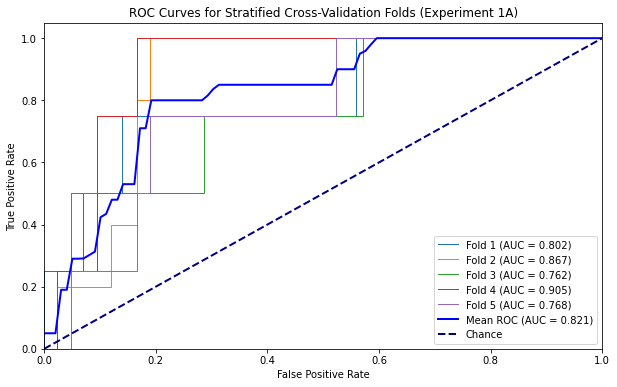

In [26]:
### xgboost auroc curves 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# setup
X = df[inputs_1a]
y = df['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store fpr and tpr for each fold
fprs = []
tprs = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='roc_auc',  # making AUROC our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
plt.figure(figsize=(10, 6))

# do stratification by outcome

scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    auroc_fold_scores = []

    # Fit model
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUROC for the current fold
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Add to AUROC, TPR, FPR, and thresholds fold scores
    auroc_fold_scores.append(auroc)

    # Compute ROC curve for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Append fpr and tpr to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current cross-validation fold
    plt.step(fprs[fold], tprs[fold], lw=1, label=f'Fold {fold+1} (AUC = {round(auroc, 3)})')

    # Add to AUROC list
    scores.append(auroc)
    
# calculate average + std AUROC score across all stratified folds
average_auroc = np.mean(scores)
print("Average AUROC Across Stratified Folds:", average_auroc)

std_auroc = np.std(scores)
print("Standard Deviation AUROC Across Stratified Folds:", std_auroc)

# Print AUROC scores for each stratified fold
for i, auroc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUROC: {auroc:.4f}")

# Calculate the mean ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Choose the number of thresholds, here chose 100
tpr_interp = []

for fold in range(len(fprs)):
    tpr_interp.append(np.interp(mean_fpr, fprs[fold], tprs[fold]))

mean_tpr = np.mean(tpr_interp, axis=0)

# plot the average ROC curve and set labels
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Mean ROC (AUC = {round(average_auroc,3)})')

# other plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stratified Cross-Validation Folds (Experiment 1A)')
plt.legend(loc='lower right')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   10.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.0s finished


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 868 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   10.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    9.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.3s finished


Average AUROC Across Outer Folds: 0.6817489487256929
Standard Deviation of AUROC Across Outer Folds: 0.16025455398255073


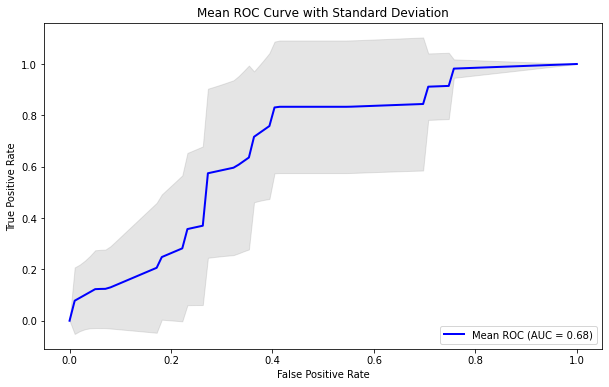

In [77]:
### xgboost auroc with group stratification and cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# data setup
X = merge_df[inputs_1a]
y = merge_df['outcome_rvedvi_hi']
groups = merge_df['mrn']  # Group identifier

# Hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}

# XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Number of splits for cross-validation
n_splits_outer = 5

# GroupKFold for outer cross-validation
outer_cv = GroupKFold(n_splits=n_splits_outer)

# Lists for storing results
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)
tpr_interpolations = []

#store feature importance per fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # RandomizedSearchCV for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='roc_auc',
        cv=3,  # You can adjust this value
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0
    tpr_interpolations.append(tpr_interp)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)

# Average auroc across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', lw=2, label=f'Mean ROC (AUC = {average_performance:.2f})')
plt.fill_between(mean_fprs, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


In [22]:
#save all 1A stuff
average_performance_1A = average_performance
std_dev_performance_1A = std_dev_performance
mean_tpr_1A = mean_tpr
std_tpr_1A = std_tpr
mean_fprs_1A = mean_fprs

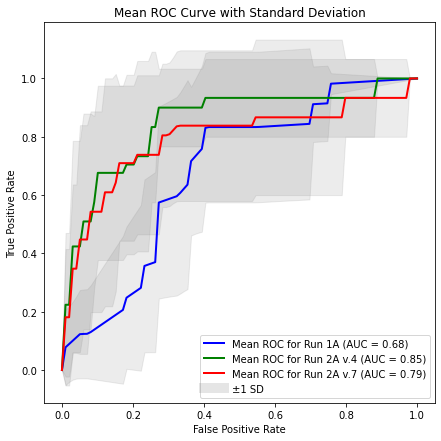

In [61]:
# Plotting the ROC curves
plt.figure(figsize=(7, 7))
plt.plot(mean_fprs_1A, mean_tpr_1A, color='b', lw=2, label=f'Mean ROC for Run 1A (AUC = {average_performance_1A:.2f})')
plt.fill_between(mean_fprs_1A, mean_tpr_1A - std_tpr_1A, mean_tpr_1A + std_tpr_1A, color='grey', alpha=0.15)

plt.plot(mean_fprs_2A4, mean_tpr_2A4, color='g', lw=2, label=f'Mean ROC for Run 2A v.4 (AUC = {average_performance_2A4:.2f})')
plt.fill_between(mean_fprs_2A4, mean_tpr_2A4 - std_tpr_2A4, mean_tpr_2A4 + std_tpr_2A4, color='grey', alpha=0.15)

plt.plot(mean_fprs_2A7, mean_tpr_2A7, color='r', lw=2, label=f'Mean ROC for Run 2A v.7 (AUC = {average_performance_2A7:.2f})')
plt.fill_between(mean_fprs_2A7, mean_tpr_2A7 - std_tpr_2A7, mean_tpr_2A7 + std_tpr_2A7, color='grey', alpha=0.15)

plt.plot([], [], color='grey', alpha=0.2, linewidth=10, label='±1 SD')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')

plt.savefig("roc_curve_rvedv.svg", format='svg')

plt.show()


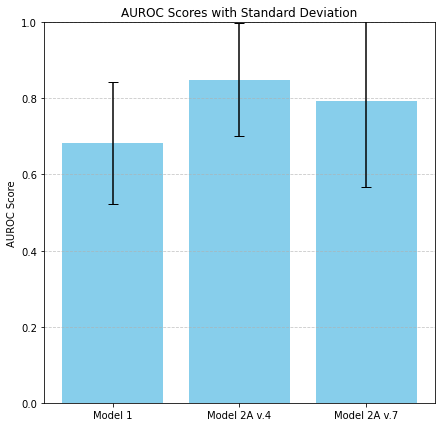

In [66]:
#make bar graph plot for aurocs
# AUROC scores and standard deviations
auroc_scores = [average_performance_1A, average_performance_2A4, average_performance_2A7]
std_devs = [std_dev_performance_1A, std_dev_performance_2A4, std_dev_performance_2A7]

# X-axis labels
labels = ['Model 1', 'Model 2A v.4', 'Model 2A v.7']

# Creating the bar plot
plt.figure(figsize=(7, 7))
plt.bar(labels, auroc_scores, yerr=std_devs, capsize=5, color='skyblue')

# Adding titles and labels
plt.ylabel('AUROC Score')
plt.title('AUROC Scores with Standard Deviation')
plt.ylim([0, 1])  # Optional: Ensuring y-axis starts at 0 and ends at 1
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Adding a grid for readability

plt.savefig("roc_barplot_rvedv.svg", format='svg')


# Show the plot
plt.show()

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished


Average AUROC Across Outer Folds: 0.7498477297895902
Standard Deviation of AUROC Across Outer Folds: 0.08754162455174323


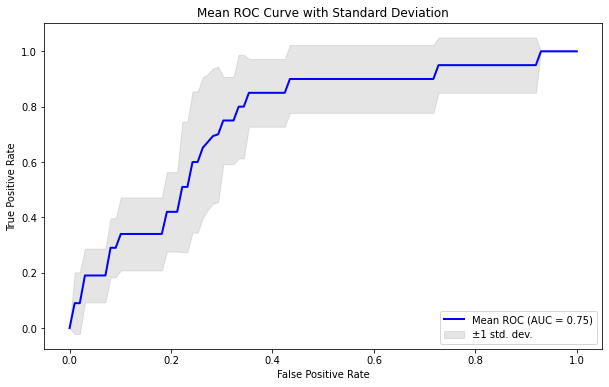

In [31]:
#xgboost auroc with nested cross validation 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# setup
X = df[inputs_1a]
y = df['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}


# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5

# make StratifiedKFold cross-validation iterator for outer CV
outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

#make list to store feature importances for each fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)
    
    #save feature importances for this fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(temp_fi)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


In [36]:
#xgboost auroc with REPEATED (20x) nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# setup
X = df[inputs_1a]
y = df['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5
n_repeats_outer = 20

# make RepeatedStratifiedKFold cross-validation iterator for outer CV
outer_cv = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

#create list to store feature importances for each fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)





Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.5s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 964 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   24.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   24.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1188 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.1s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.0s


Average AUROC Across Outer Folds: 0.7460247785160575
Standard Deviation of AUROC Across Outer Folds: 0.108918493130798


[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.4s finished


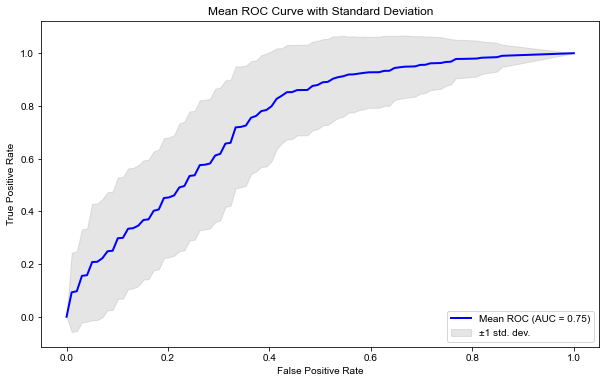

In [56]:
# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')

plt.savefig('1a_auroc_graph.svg', format='svg')

plt.show()

In [40]:
#get mean and std dev of feature importances 

col0 = []
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []
col7 = []
col8 = []



for f in feature_importances:
    
    count = 0
    for i in f:
        if count == 0:
            col0.append(i)
        if count == 1:
            col1.append(i)
        if count == 2:
            col2.append(i)
        if count == 3:
            col3.append(i)
        if count == 4:
            col4.append(i)
        if count == 5:
            col5.append(i)
        if count == 6:
            col6.append(i)
        if count == 7:
            col7.append(i)
        if count == 8:
            col8.append(i)
            
        count = count + 1
            
            


In [51]:
print(np.mean(col8))
print(np.std(col8))

0.099158436
0.04733329


In [39]:
#get feature importances for each fold

#print(feature_importances)

for i in X_train.columns:
    print(i)

rvenddiastolicareacm2ap
rvbasalenddiastolicdimension
rvmidenddiastolicdimension
rvlengthenddiastolicdimensio
rvendsystolicareacm2ap4
rvotproximal12oclockdiast
rvotdistaljustbelowpulmvlv
tvannulusdimensionindiastole
bsaonmri


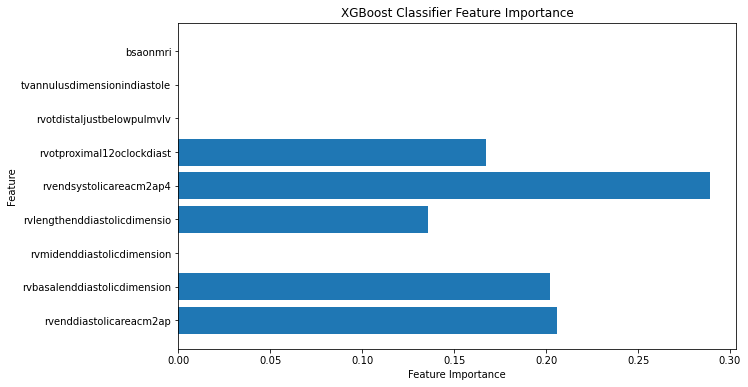

In [27]:
## get feature importance

feature_importance = best_xgb_model.feature_importances_
feature_names = X_train.columns
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Classifier Feature Importance')
plt.show()

In [29]:
print(sum(feature_importance))

1.0000000298023224


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:   23.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   23.9s finished


Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 100, 'min_child_weight': 0.1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Average AUPRC Across Stratified Folds: 0.38300715425578086
Standard Deviation AUPRC Across Stratified Folds: 0.10933910845215743
Stratified Fold 1 AUPRC: 0.2700
Stratified Fold 2 AUPRC: 0.4130
Stratified Fold 3 AUPRC: 0.2420
Stratified Fold 4 AUPRC: 0.5190
Stratified Fold 5 AUPRC: 0.4710


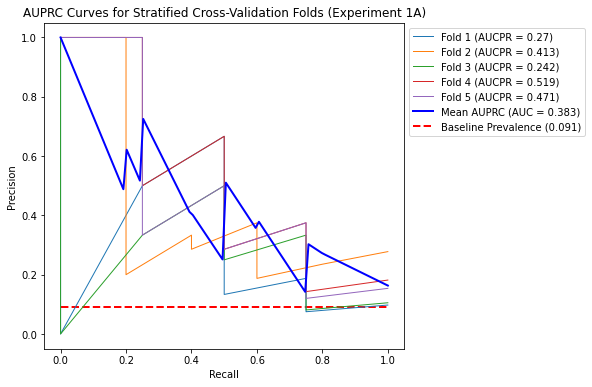

In [11]:
########## xgboost PR curves


from sklearn.metrics import precision_recall_curve, auc

# setup
X = df[inputs_1a]
y = df['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='average_precision',  # making avg precision our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))


# do stratification by outcome
scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model
    best_xgb_model.fit(X_train, y_train)

    #  probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # do PR curve vals
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # store precision and recall per fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # plot the PR curve for the current cross-validation fold
    ax.plot(recalls_list[fold], precisions_list[fold], lw=1, label=f'Fold {fold+1} (AUCPR = {round(auc_pr, 3)})')

    # Add AUC-PR to the scores list
    scores.append(auc_pr)

# calculate average AUC-PR score across all stratified folds
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Folds:", std_aucpr)

# Print AUROC scores for each stratified fold
for i, auprc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUPRC: {auprc:.4f}")

baseline_prevalence = y.mean()



# calculate the mean PR curve - must do sorting and interpolation to fit data correctly
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# plot  mean PR curve
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# plot the chance PR curve (should be a diagonal line from 0,1 to 1,0)
#plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2, label='Chance')

# Plot baseline prevalence as a horizontal line
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')


# Adjust layout to make room for the legend
plt.subplots_adjust(right=0.75)

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Other plot settings
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('AUPRC Curves for Stratified Cross-Validation Folds (Experiment 1A)')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    6.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.5s finished


Average AUPRC Across Group-Stratified Folds: 0.274286123636081
Average AUPRC Across Group-Stratified Folds: 0.14524322186999916


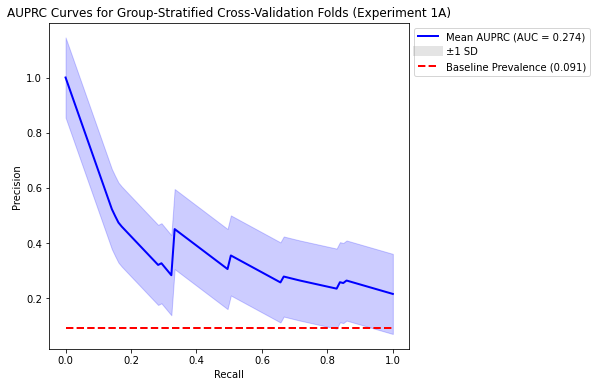

In [36]:
#xgboost pr curves with group strat + nested cv loops

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# setup
X = merge_df[inputs_1a]
y = merge_df['outcome_rvedvi_hi']
groups = merge_df['mrn']  # Group identifier column

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# Number of splits for outer and inner cross-validation
n_splits_outer = 5
n_splits_inner = 3

# GroupKFold for outer cross-validation
outer_group_kfold = GroupKFold(n_splits=n_splits_outer)

# Lists to store results
precisions_list = []
recalls_list = []
average_aucpr_scores = []

# Outer cross-validation loop
for train_index, test_index in outer_group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups.iloc[train_index]

    # XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # GroupKFold for inner cross-validation (hyperparameter tuning)
    inner_group_kfold = GroupKFold(n_splits=n_splits_inner)

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='average_precision',
        cv=inner_group_kfold.split(X_train, y_train, groups_train),
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # PR curve values
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    precisions_list.append(precision)
    recalls_list.append(recall)

    # AUC-PR
    auc_pr = auc(recall, precision)
    average_aucpr_scores.append(auc_pr)

# Calculate and print the average and standard deviation performance across all outer folds
average_aucpr = np.mean(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", average_aucpr)
std_aucpr = np.std(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", std_aucpr)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
mean_recall = np.linspace(0, 1, 100)
precision_interp = []

# Interpolate and plot each fold's precision-recall curve
for recall, precision in zip(recalls_list, precisions_list):
    recall_sorted, precision_sorted = zip(*sorted(zip(recall, precision)))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

baseline_prevalence = y.mean()
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')

ax.fill_between(mean_recall, mean_precision - std_aucpr, mean_precision + std_aucpr, color='blue', alpha=0.2)
plt.plot([], [], color='grey', alpha=0.2, linewidth=10, label='±1 SD')


plt.subplots_adjust(right=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curves for Group-Stratified Cross-Validation Folds (Experiment 1A)')
plt.show()


In [38]:
#save 1A stuff

mean_precision_1A = mean_precision
mean_recall_1A = mean_recall
average_aucpr_1A = average_aucpr
std_aucpr_1A = std_aucpr
baseline_prevalence_1A = baseline_prevalence

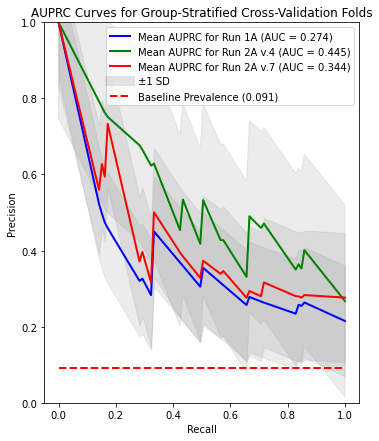

In [68]:
#overlaying plots
# Plotting
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(mean_recall_1A, mean_precision_1A, color='b', linestyle='-', lw=2, label=f'Mean AUPRC for Run 1A (AUC = {round(average_aucpr_1A, 3)})')

ax.hlines(baseline_prevalence_1A, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence_1A, 3)})')

ax.fill_between(mean_recall_1A, mean_precision_1A - std_aucpr_1A, mean_precision_1A + std_aucpr_1A, color='gray', alpha=0.15)


ax.plot(mean_recall_2A4, mean_precision_2A4, color='g', linestyle='-', lw=2, label=f'Mean AUPRC for Run 2A v.4 (AUC = {round(average_aucpr_2A4, 3)})')

#ax.hlines(baseline_prevalence_2A4, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence_2A4, 3)})')

ax.fill_between(mean_recall_2A4, mean_precision_2A4 - std_aucpr_2A4, mean_precision_2A4 + std_aucpr_2A4, color='gray', alpha=0.15)


ax.plot(mean_recall_2A7, mean_precision_2A7, color='r', linestyle='-', lw=2, label=f'Mean AUPRC for Run 2A v.7 (AUC = {round(average_aucpr_2A7, 3)})')

#ax.hlines(baseline_prevalence_2A7, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence_2A7, 3)})')

ax.fill_between(mean_recall_2A7, mean_precision_2A7 - std_aucpr_2A7, mean_precision_2A7 + std_aucpr_2A7, color='gray', alpha=0.15)


plt.plot([], [], color='grey', alpha=0.2, linewidth=10, label='±1 SD')

plt.ylim([0, 1])  # Setting y-axis limits from 0 to 1

plt.subplots_adjust(right=0.75)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curves for Group-Stratified Cross-Validation Folds')

plt.savefig("pr_curve_with_std.svg", format='svg')

plt.show()

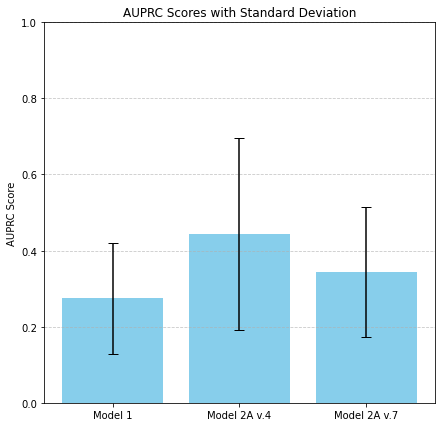

In [67]:
#bar plot for pr 

#make bar graph plot for aurocs
# AUROC scores and standard deviations
auroc_scores = [average_aucpr_1A, average_aucpr_2A4, average_aucpr_2A7]
std_devs = [std_aucpr_1A, std_aucpr_2A4, std_aucpr_2A7]

# X-axis labels
labels = ['Model 1', 'Model 2A v.4', 'Model 2A v.7']

# Creating the bar plot
plt.figure(figsize=(7, 7))
plt.bar(labels, auroc_scores, yerr=std_devs, capsize=5, color='skyblue')

# Adding titles and labels
plt.ylabel('AUPRC Score')
plt.title('AUPRC Scores with Standard Deviation')
plt.ylim([0, 1])  # Optional: Ensuring y-axis starts at 0 and ends at 1
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Adding a grid for readability

plt.savefig("pr_barplot_rvedv.svg", format='svg')


# Show the plot
plt.show()

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 1 AUC-PR: 0.3493
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    6.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 2 AUC-PR: 0.4055
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 3 AUC-PR: 0.1271
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 4 AUC-PR: 0.2742
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.7s finished


Outer Fold 5 AUC-PR: 0.2025
Average AUPRC Across Stratified Outer Folds: 0.2717019944648621
Standard Deviation AUPRC Across Stratified Outer Folds: 0.09962880584677916


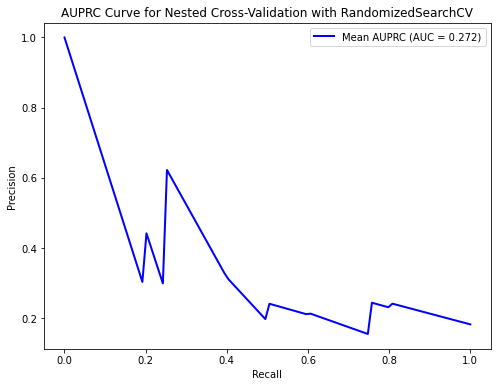

In [7]:
#pr curves using nested cv

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df[inputs_1a]
y = df['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make StratifiedKFold cross-validation iterator for outer cross-validation
n_outer_splits = 5  # Number of outer splits
outer_stratified_kfold = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# Outer loop: iterate over outer folds
for outer_fold, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {outer_fold+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
scores = [auc(recalls_list[i], precisions_list[i]) for i in range(len(recalls_list))]
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.1s finished


Outer Fold 1 AUC-PR: 0.1111
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 2 AUC-PR: 0.2442
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.1s finished


Outer Fold 3 AUC-PR: 0.1352
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 4 AUC-PR: 0.2609
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 5 AUC-PR: 0.1708
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 6 AUC-PR: 0.1245
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 7 AUC-PR: 0.5202
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.9s finished


Outer Fold 8 AUC-PR: 0.1025
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished


Outer Fold 9 AUC-PR: 0.5879
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 10 AUC-PR: 0.3133
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished


Outer Fold 11 AUC-PR: 0.6981
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 12 AUC-PR: 0.1362
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 13 AUC-PR: 0.1671
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 14 AUC-PR: 0.0710
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 15 AUC-PR: 0.2752
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 16 AUC-PR: 0.0952
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 17 AUC-PR: 0.4395
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 18 AUC-PR: 0.4765
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 19 AUC-PR: 0.1121
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished


Outer Fold 20 AUC-PR: 0.4061
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 21 AUC-PR: 0.3571
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 22 AUC-PR: 0.1700
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 23 AUC-PR: 0.2476
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished


Outer Fold 24 AUC-PR: 0.1381
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 25 AUC-PR: 0.3906
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 26 AUC-PR: 0.1376
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 27 AUC-PR: 0.4199
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 28 AUC-PR: 0.6920
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 29 AUC-PR: 0.2122
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 30 AUC-PR: 0.7133
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished


Outer Fold 31 AUC-PR: 0.5005
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 32 AUC-PR: 0.3817
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 33 AUC-PR: 0.1220
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished


Outer Fold 34 AUC-PR: 0.3794
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 35 AUC-PR: 0.3283
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 36 AUC-PR: 0.3184
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 37 AUC-PR: 0.3703
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 38 AUC-PR: 0.1448
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 39 AUC-PR: 0.1900
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 40 AUC-PR: 0.3630
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 41 AUC-PR: 0.2499
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 42 AUC-PR: 0.2273
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 43 AUC-PR: 0.2042
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 44 AUC-PR: 0.3946
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 45 AUC-PR: 0.2453
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 46 AUC-PR: 0.0856
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 47 AUC-PR: 0.4546
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 48 AUC-PR: 0.1835
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 49 AUC-PR: 0.3643
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 50 AUC-PR: 0.4601
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 51 AUC-PR: 0.2832
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 52 AUC-PR: 0.1502
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 53 AUC-PR: 0.1400
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 54 AUC-PR: 0.5873
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 55 AUC-PR: 0.2640
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 56 AUC-PR: 0.1885
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 57 AUC-PR: 0.7102
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 58 AUC-PR: 0.1432
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 59 AUC-PR: 0.2381
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 60 AUC-PR: 0.1191
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 61 AUC-PR: 0.4649
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 62 AUC-PR: 0.1730
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 63 AUC-PR: 0.1792
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 64 AUC-PR: 0.4280
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 65 AUC-PR: 0.1241
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 66 AUC-PR: 0.1942
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 67 AUC-PR: 0.1119
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished


Outer Fold 68 AUC-PR: 0.4410
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 69 AUC-PR: 0.4997
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 70 AUC-PR: 0.1630
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 71 AUC-PR: 0.1089
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 72 AUC-PR: 0.2070
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 73 AUC-PR: 0.5308
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 74 AUC-PR: 0.1068
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 75 AUC-PR: 0.1384
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 76 AUC-PR: 0.1750
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 77 AUC-PR: 0.1293
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 78 AUC-PR: 0.4324
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 79 AUC-PR: 0.1373
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 80 AUC-PR: 0.1218
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 81 AUC-PR: 0.4288
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 82 AUC-PR: 0.1869
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 83 AUC-PR: 0.4953
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 84 AUC-PR: 0.3880
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 85 AUC-PR: 0.1711
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 86 AUC-PR: 0.3281
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 87 AUC-PR: 0.3463
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 88 AUC-PR: 0.2415
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 89 AUC-PR: 0.1661
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 90 AUC-PR: 0.0853
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 91 AUC-PR: 0.2917
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 92 AUC-PR: 0.1677
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 93 AUC-PR: 0.1496
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 94 AUC-PR: 0.1040
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 95 AUC-PR: 0.3723
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 96 AUC-PR: 0.1104
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 97 AUC-PR: 0.4411
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 98 AUC-PR: 0.1698
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 99 AUC-PR: 0.3720
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.2s finished


Outer Fold 100 AUC-PR: 0.1699
Average AUPRC Across Stratified Outer Folds: 0.27769842640726533
Standard Deviation AUPRC Across Stratified Outer Folds: 0.16006481525892904


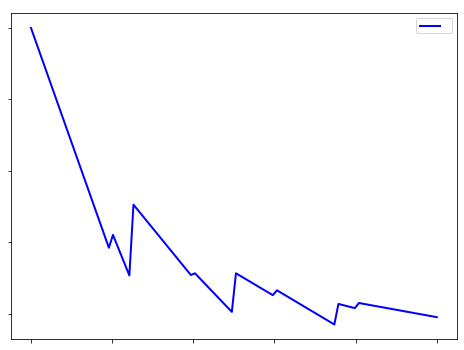

In [52]:
#pr curves using REPEATED nested cv

from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df[inputs_1a]
y = df['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits and repeats for outer cross-validation
n_splits_outer = 5  # Number of outer splits
n_repeats_outer = 20  # Number of repeats

# make RepeatedStratifiedKFold cross-validation iterator for outer cross-validation
outer_repeated_stratified_kfold = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=42)

# Lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

outer_fold_auprcs = []

# Outer Cross-Validation loop
for i, (train_index, test_index) in enumerate(outer_repeated_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # add auc_pr to list
    outer_fold_auprcs.append(auc_pr)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {i+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
average_aucpr = np.mean(outer_fold_auprcs)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(outer_fold_auprcs)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


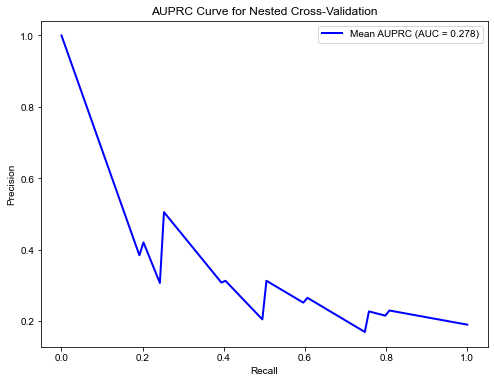

In [55]:
# plot mean PR curve

plt.rcParams['font.sans-serif'] = 'Arial'

plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation')
plt.legend()

plt.savefig('1a_auprc_graph.svg', format='svg')

plt.show()

In [8]:
##### Experiment 1B ########
inputs_1b = inputs_1a

In [9]:
df_1b = df

In [10]:
df_1b = df_1b.dropna(subset=['outcome_rvesv_hi'])


In [77]:
df_1b

,studyid,age_y_at_echo,sex,pulmonaryoutflowtypeattimeo,degreeofprbyechoreportif,degreeoftrbyechoreportif,tapsecmap4cviewmmode,rvs1tdicmsap4cviewtd,tvangulartiltdegreesap4c,mvannulusdimensioncmap4c,...,antegradediastolicflowateith,pslarvotdiastolicdimensionc,tvannulusdimensionindiastole,weightonmri,heightonmri,bsaonmri,rv_fac,outcome_rvef_low,outcome_rvedvi_hi,outcome_rvesv_hi
0,1545,13.000000,0,2,2,1,2.15,11.00,-6.60,2.71,...,0.0,3.83,2.43,72.00,158.00,1.80,0.520932,0.0,0,0.0
1,1154,17.000000,1,1,5,1,2.65,9.90,6.06,2.70,...,1.0,3.57,3.28,54.50,171.50,1.60,0.608557,1.0,1,1.0
2,1269,34.000000,0,1,3,0,1.78,8.15,4.09,3.39,...,1.0,2.59,4.25,65.00,168.00,1.75,0.554206,1.0,0,0.0
3,1452,9.900000,1,2,5,1,1.99,12.23,5.10,2.51,...,1.0,2.70,2.76,28.00,131.00,1.01,0.434833,0.0,0,0.0
4,1124,5.219178,0,2,3,3,0.58,8.36,-11.39,2.28,...,1.0,2.26,2.58,65.00,167.00,1.74,0.597867,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1050,53.852055,0,1,3,0,1.75,10.33,-4.68,2.52,...,1.0,3.15,2.50,65.50,165.99,1.73,0.538928,0.0,0,0.0
228,1041,56.323288,0,2,3,0,2.63,14.45,4.90,1.79,...,NaN,3.90,3.80,88.45,167.00,1.97,0.612187,0.0,0,0.0
229,1114,58.024658,0,8,5,0,1.78,8.92,-3.99,2.67,...,0.0,2.73,2.68,57.50,148.00,1.55,0.670692,1.0,0,1.0
230,1027,69.249315,1,2,1,2,2.97,15.00,-14.82,3.54,...,0.0,3.68,5.36,76.00,177.00,1.93,0.583491,0.0,1,1.0


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 4112 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   26.2s finished


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 10.0, 'reg_alpha': 0.5, 'n_estimators': 10, 'min_child_weight': 0.1, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
Average AUROC Across Stratified Folds: 0.7322619047619048
Standard Deviation AUROC Across Stratified Folds: 0.10074316398993508
Stratified Fold 1 AUROC: 0.7196
Stratified Fold 2 AUROC: 0.7958
Stratified Fold 3 AUROC: 0.8896
Stratified Fold 4 AUROC: 0.6208
Stratified Fold 5 AUROC: 0.6354


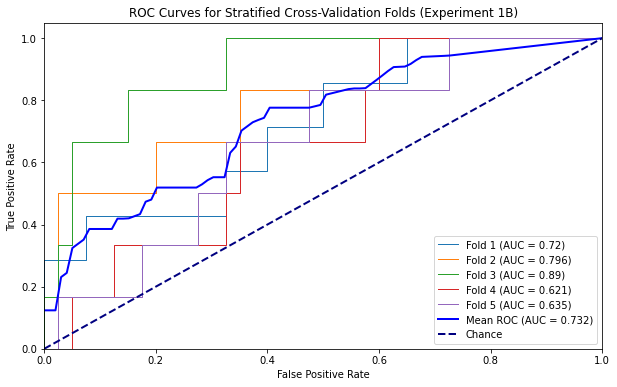

In [49]:
### xgboost auroc curves 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# setup
X = df_1b[inputs_1b]
y = df_1b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store fpr and tpr for each fold
fprs = []
tprs = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='roc_auc',  # making AUROC our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
plt.figure(figsize=(10, 6))

# do stratification by outcome

scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    auroc_fold_scores = []

    # Fit model
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUROC for the current fold
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Add to AUROC, TPR, FPR, and thresholds fold scores
    auroc_fold_scores.append(auroc)

    # Compute ROC curve for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Append fpr and tpr to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current cross-validation fold
    plt.step(fprs[fold], tprs[fold], lw=1, label=f'Fold {fold+1} (AUC = {round(auroc, 3)})')

    # Add to AUROC list
    scores.append(auroc)
    
# calculate average + std AUROC score across all stratified folds
average_auroc = np.mean(scores)
print("Average AUROC Across Stratified Folds:", average_auroc)

std_auroc = np.std(scores)
print("Standard Deviation AUROC Across Stratified Folds:", std_auroc)

# Print AUROC scores for each stratified fold
for i, auroc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUROC: {auroc:.4f}")

# Calculate the mean ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Choose the number of thresholds, here chose 100
tpr_interp = []

for fold in range(len(fprs)):
    tpr_interp.append(np.interp(mean_fpr, fprs[fold], tprs[fold]))

mean_tpr = np.mean(tpr_interp, axis=0)

# plot the average ROC curve and set labels
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Mean ROC (AUC = {round(average_auroc,3)})')

# other plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stratified Cross-Validation Folds (Experiment 1B)')
plt.legend(loc='lower right')
plt.show()


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished


Average AUROC Across Outer Folds: 0.5730357142857143
Standard Deviation of AUROC Across Outer Folds: 0.10688388013259788


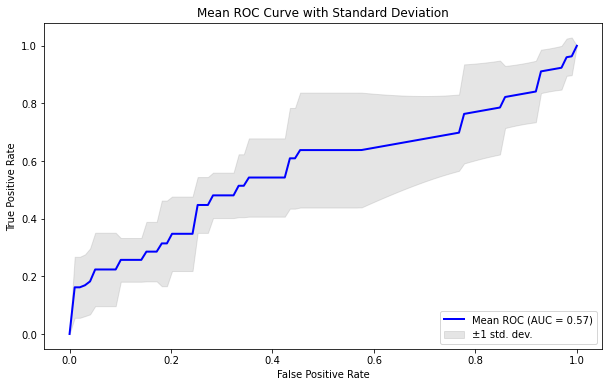

In [78]:
#xgboost auroc with nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_1b[inputs_1b]
y = df_1b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}


# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5

# make StratifiedKFold cross-validation iterator for outer CV
outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:   26.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   26.4s finished


Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'n_estimators': 10, 'min_child_weight': 0.5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Average AUPRC Across Stratified Folds: 0.4900351039763374
Standard Deviation AUPRC Across Stratified Folds: 0.17188395546260432
Stratified Fold 1 AUPRC: 0.4909
Stratified Fold 2 AUPRC: 0.5093
Stratified Fold 3 AUPRC: 0.7517
Stratified Fold 4 AUPRC: 0.4892
Stratified Fold 5 AUPRC: 0.2091


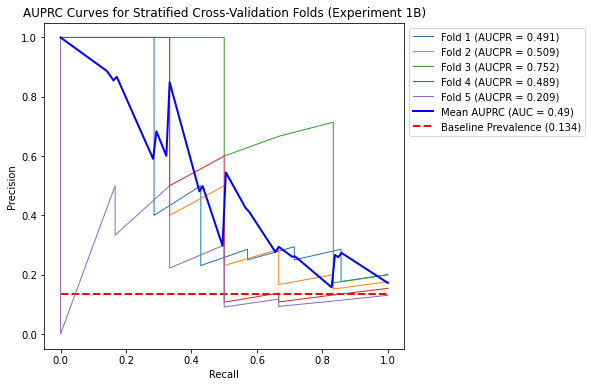

In [51]:
########## xgboost PR curves


from sklearn.metrics import precision_recall_curve, auc

# setup
X = df_1b[inputs_1b]
y = df_1b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='average_precision',  # making avg precision our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))


# do stratification by outcome
scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model
    best_xgb_model.fit(X_train, y_train)

    #  probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # do PR curve vals
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # store precision and recall per fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # plot the PR curve for the current cross-validation fold
    ax.plot(recalls_list[fold], precisions_list[fold], lw=1, label=f'Fold {fold+1} (AUCPR = {round(auc_pr, 3)})')

    # Add AUC-PR to the scores list
    scores.append(auc_pr)

# calculate average AUC-PR score across all stratified folds
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Folds:", std_aucpr)

# Print AUROC scores for each stratified fold
for i, auprc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUPRC: {auprc:.4f}")

baseline_prevalence = y.mean()



# calculate the mean PR curve - must do sorting and interpolation to fit data correctly
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# plot  mean PR curve
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# plot the chance PR curve (should be a diagonal line from 0,1 to 1,0)
#plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2, label='Chance')

# Plot baseline prevalence as a horizontal line
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')


# Adjust layout to make room for the legend
plt.subplots_adjust(right=0.75)

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Other plot settings
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('AUPRC Curves for Stratified Cross-Validation Folds (Experiment 1B)')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 1 AUC-PR: 0.3057
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    8.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 2 AUC-PR: 0.5480
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    8.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.3s finished


Outer Fold 3 AUC-PR: 0.4015
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.6s finished


Outer Fold 4 AUC-PR: 0.1873
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.5s finished


Outer Fold 5 AUC-PR: 0.1513
Average AUPRC Across Stratified Outer Folds: 0.3187686815276859
Standard Deviation AUPRC Across Stratified Outer Folds: 0.14485858061322104


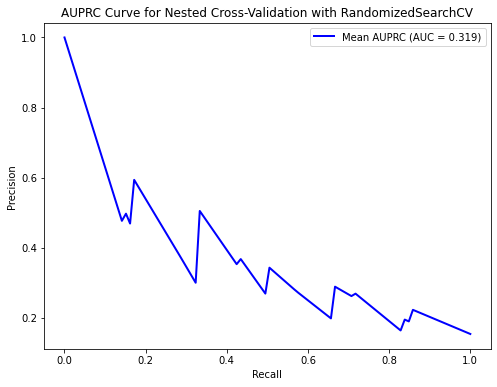

In [11]:
#pr curves using nested cv

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df_1b[inputs_1b]
y = df_1b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make StratifiedKFold cross-validation iterator for outer cross-validation
n_outer_splits = 5  # Number of outer splits
outer_stratified_kfold = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# Outer loop: iterate over outer folds
for outer_fold, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {outer_fold+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
scores = [auc(recalls_list[i], precisions_list[i]) for i in range(len(recalls_list))]
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


In [13]:
##### Experiment 2A #####

inputs_2a = ['age_y_at_echo',
'sex',
'pulmonaryoutflowtypeattimeo_2', 'pulmonaryoutflowtypeattimeo_1', 'pulmonaryoutflowtypeattimeo_5', 'pulmonaryoutflowtypeattimeo_3', 'pulmonaryoutflowtypeattimeo_8', 'pulmonaryoutflowtypeattimeo_7', 'pulmonaryoutflowtypeattimeo_6',
'degreeofprbyechoreportif_1', 'degreeofprbyechoreportif_2', 'degreeofprbyechoreportif_3', 'degreeofprbyechoreportif_4', 'degreeofprbyechoreportif_5',
'degreeoftrbyechoreportif_0', 'degreeoftrbyechoreportif_1', 'degreeoftrbyechoreportif_2', 'degreeoftrbyechoreportif_3', 'degreeoftrbyechoreportif_4', 'degreeoftrbyechoreportif_5', 'degreeoftrbyechoreportif_6',
'tapsecmap4cviewmmode',
'rvs1tdicmsap4cviewtd',
'tvangulartiltdegreesap4c',
'mvannulusdimensioncmap4c',
'rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvmidenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvendsystolicareacm2ap4',
'aovalvesystolicannulardimens',
'pslaxpulmvalveannulusindias',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'pssapulmvalveannulusindiast',
'pssapulmvalveannulusinsysto',
'mpadiastolicflowreversalpres',
'branchpaatleastonediastol',
'antegradediastolicflowateith',
'pslarvotdiastolicdimensionc',
'tvannulusdimensionindiastole',
'weightonmri',
'heightonmri',
'bsaonmri',
'rv_fac']

In [14]:
len(inputs_2a)

45

In [18]:
inputs_2a_new_run2 = ['age_y_at_echo',
'degreeofprbyechoreportif_5',
'degreeoftrbyechoreportif_0',
'tapsecmap4cviewmmode',
'rvs1tdicmsap4cviewtd',
'tvangulartiltdegreesap4c',
'mvannulusdimensioncmap4c',
'rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvmidenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvendsystolicareacm2ap4',
'aovalvesystolicannulardimens',
'pslaxpulmvalveannulusindias',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'pssapulmvalveannulusindiast',
'pssapulmvalveannulusinsysto',
'branchpaatleastonediastol',
'pslarvotdiastolicdimensionc',
'tvannulusdimensionindiastole',
'weightonmri',
'heightonmri',
'rv_fac']

In [20]:
inputs_2a_new_run3 = ['weightonmri',
'heightonmri',
'rvendsystolicareacm2ap4',
'aovalvesystolicannulardimens',
'mvannulusdimensioncmap4c',
'tvannulusdimensionindiastole',
'rvs1tdicmsap4cviewtd',
'rvotdistaljustbelowpulmvlv',
'tvangulartiltdegreesap4c',
'pssapulmvalveannulusindiast',
'rvmidenddiastolicdimension',
'tapsecmap4cviewmmode',
'rvotproximal12oclockdiast',
'age_y_at_echo',
'rvbasalenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'degreeofprbyechoreportif_5',
'rvenddiastolicareacm2ap',
'pslarvotdiastolicdimensionc']

In [21]:
inputs_2a_new_run4 = ['heightonmri',
'tvannulusdimensionindiastole',
'age_y_at_echo',
'tvangulartiltdegreesap4c',
'pssapulmvalveannulusindiast',
'rvbasalenddiastolicdimension',
'tapsecmap4cviewmmode',
'degreeofprbyechoreportif_5',
'rvotproximal12oclockdiast',
'rvlengthenddiastolicdimensio',
'pslarvotdiastolicdimensionc',
'rvenddiastolicareacm2ap']

In [37]:
inputs_2a_new_run5 = ['heightonmri',
'tvangulartiltdegreesap4c',
'pssapulmvalveannulusindiast',
'rvlengthenddiastolicdimensio',
'degreeofprbyechoreportif_5',
'rvbasalenddiastolicdimension',
'rvotproximal12oclockdiast',
'tapsecmap4cviewmmode',
'pslarvotdiastolicdimensionc',
'rvenddiastolicareacm2ap']

In [9]:
inputs_2a_new_run6 = ['heightonmri',
'tvangulartiltdegreesap4c',
'pssapulmvalveannulusindiast',
'rvlengthenddiastolicdimensio',
'rvbasalenddiastolicdimension',
'rvotproximal12oclockdiast',
'pslarvotdiastolicdimensionc',
'rvenddiastolicareacm2ap']

In [15]:
inputs_2a_new_run7 = ['heightonmri',
'tvannulusdimensionindiastole',
'age_y_at_echo',
'tvangulartiltdegreesap4c',
'pssapulmvalveannulusindiast',
'rvbasalenddiastolicdimension',
'tapsecmap4cviewmmode',
'rvotproximal12oclockdiast',
'rvlengthenddiastolicdimensio',
'pslarvotdiastolicdimensionc',
'rvenddiastolicareacm2ap']

In [24]:
inputs_2a_run1 = ['age_y_at_echo',
'degreeofprbyechoreportif_1',
'degreeofprbyechoreportif_2',
'degreeofprbyechoreportif_3',
'degreeofprbyechoreportif_4',
'degreeofprbyechoreportif_5',
'tr_greater_than_mild',
'new_pulm_outflow_col_1',
'new_pulm_outflow_col_2',
'new_pulm_outflow_col_3',
'tapsecmap4cviewmmode',
'rvs1tdicmsap4cviewtd',
'tvangulartiltdegreesap4c',
'mvannulusdimensioncmap4c',
'rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvmidenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvendsystolicareacm2ap4',
'aovalvesystolicannulardimens',
'pslaxpulmvalveannulusindias',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'pssapulmvalveannulusindiast',
'pssapulmvalveannulusinsysto',
'mpadiastolicflowreversalpres',
'branchpaatleastonediastol',
'antegradediastolicflowateith',
'pslarvotdiastolicdimensionc',
'tvannulusdimensionindiastole',
'weightonmri',
'heightonmri',
'bsaonmri',
'rv_fac']

In [17]:
inputs_2a_2 = ['age_y_at_echo',
'rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'pssapulmvalveannulusinsysto',
'pslarvotdiastolicdimensionc',
'tvannulusdimensionindiastole',
'weightonmri',
'heightonmri']

In [30]:
inputs_2a_run4 = ['age_y_at_echo',
'degreeofprbyechoreportif_5',
'rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'pssapulmvalveannulusinsysto',
'pslarvotdiastolicdimensionc',
'tvannulusdimensionindiastole',
'weightonmri',
'heightonmri']

In [34]:
inputs_2a_run5 = ['age_y_at_echo',
'rvenddiastolicareacm2ap',
'rvbasalenddiastolicdimension',
'rvlengthenddiastolicdimensio',
'rvotproximal12oclockdiast',
'rvotdistaljustbelowpulmvlv',
'pssapulmvalveannulusinsysto',
'pslarvotdiastolicdimensionc',
'tvannulusdimensionindiastole',
'weightonmri',
'heightonmri']

In [15]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(merge_df, columns=['pulmonaryoutflowtypeattimeo', 'degreeofprbyechoreportif', 'degreeoftrbyechoreportif'])


In [23]:
# Apply one-hot encoding - to updated dataset (df_2)
df_encoded_2 = pd.get_dummies(df_2, columns=['new_pulm_outflow_col', 'degreeofprbyechoreportif'])


NameError: name 'df_2' is not defined

In [17]:
df_encoded_2.columns

Index(['studyid', 'age_y_at_echo', 'tapsecmap4cviewmmode',
       'rvs1tdicmsap4cviewtd', 'tvangulartiltdegreesap4c',
       'mvannulusdimensioncmap4c', 'rvenddiastolicareacm2ap',
       'rvbasalenddiastolicdimension', 'rvmidenddiastolicdimension',
       'rvlengthenddiastolicdimensio', 'rvendsystolicareacm2ap4',
       'aovalvesystolicannulardimens', 'pslaxpulmvalveannulusindias',
       'rvotproximal12oclockdiast', 'rvotdistaljustbelowpulmvlv',
       'pssapulmvalveannulusindiast', 'pssapulmvalveannulusinsysto',
       'mpadiastolicflowreversalpres', 'branchpaatleastonediastol',
       'antegradediastolicflowateith', 'pslarvotdiastolicdimensionc',
       'tvannulusdimensionindiastole', 'weightonmri', 'heightonmri',
       'bsaonmri', 'rv_fac', 'outcome_rvef_low', 'outcome_rvedvi_hi',
       'outcome_rvesv_hi', 'tr_greater_than_mild', 'new_pulm_outflow_col_1',
       'new_pulm_outflow_col_2', 'new_pulm_outflow_col_3',
       'degreeofprbyechoreportif_1', 'degreeofprbyechoreportif_2',


In [29]:
df_encoded_2['outcome_rvedvi_hi'].value_counts()

0    211
1     21
Name: outcome_rvedvi_hi, dtype: int64

In [88]:
len(df_encoded_2['mrn'].unique())

158

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1172 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:   53.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   53.5s finished


Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 50, 'min_child_weight': 0.1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Average AUROC Across Stratified Folds: 0.8761018826135105
Standard Deviation AUROC Across Stratified Folds: 0.08488574431290966
Stratified Fold 1 AUROC: 0.9186
Stratified Fold 2 AUROC: 0.8190
Stratified Fold 3 AUROC: 0.7381
Stratified Fold 4 AUROC: 0.9643
Stratified Fold 5 AUROC: 0.9405


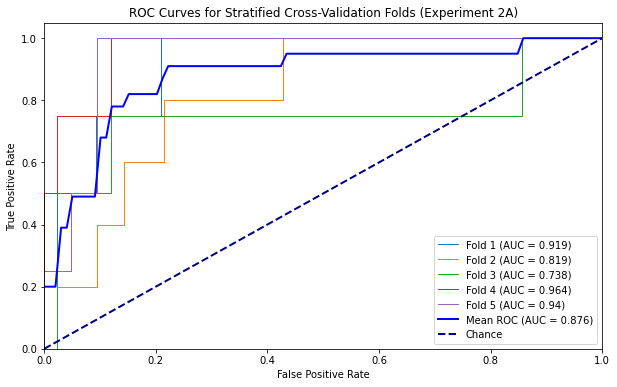

In [56]:
### xgboost auroc curves 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# setup
X = df_encoded[inputs_2a]
y = df_encoded['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store fpr and tpr for each fold
fprs = []
tprs = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='roc_auc',  # making AUROC our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
plt.figure(figsize=(10, 6))

# do stratification by outcome

scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    auroc_fold_scores = []

    # Fit model
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUROC for the current fold
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Add to AUROC, TPR, FPR, and thresholds fold scores
    auroc_fold_scores.append(auroc)

    # Compute ROC curve for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Append fpr and tpr to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current cross-validation fold
    plt.step(fprs[fold], tprs[fold], lw=1, label=f'Fold {fold+1} (AUC = {round(auroc, 3)})')

    # Add to AUROC list
    scores.append(auroc)
    
# calculate average + std AUROC score across all stratified folds
average_auroc = np.mean(scores)
print("Average AUROC Across Stratified Folds:", average_auroc)

std_auroc = np.std(scores)
print("Standard Deviation AUROC Across Stratified Folds:", std_auroc)

# Print AUROC scores for each stratified fold
for i, auroc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUROC: {auroc:.4f}")

# Calculate the mean ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Choose the number of thresholds, here chose 100
tpr_interp = []

for fold in range(len(fprs)):
    tpr_interp.append(np.interp(mean_fpr, fprs[fold], tprs[fold]))

mean_tpr = np.mean(tpr_interp, axis=0)

# plot the average ROC curve and set labels
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Mean ROC (AUC = {round(average_auroc,3)})')

# other plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stratified Cross-Validation Folds (Experiment 2A)')
plt.legend(loc='lower right')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    9.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    9.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.8s finished


Average AUROC Across Outer Folds: 0.8489693897833431
Standard Deviation of AUROC Across Outer Folds: 0.1485497427671051


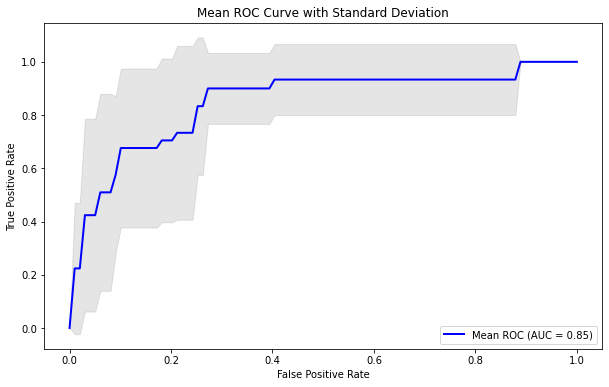

In [24]:
### xgboost auroc with group stratification + nested cv

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

X = df_encoded[inputs_2a_new_run4]
y = df_encoded['outcome_rvedvi_hi']
groups = df_encoded['mrn']  # Group identifier

# Hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}

# XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Number of splits for cross-validation
n_splits_outer = 5

# GroupKFold for outer cross-validation
outer_cv = GroupKFold(n_splits=n_splits_outer)

# Lists for storing results
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)
tpr_interpolations = []

#save feature importances per fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # RandomizedSearchCV for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='roc_auc',
        cv=3,  # You can adjust this value
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0
    tpr_interpolations.append(tpr_interp)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)

# Average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', lw=2, label=f'Mean ROC (AUC = {average_performance:.2f})')
plt.fill_between(mean_fprs, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


In [25]:
mean_tpr

array([0.        , 0.22380952, 0.22380952, 0.42380952, 0.42380952,
       0.42380952, 0.50952381, 0.50952381, 0.50952381, 0.57619048,
       0.67619048, 0.67619048, 0.67619048, 0.67619048, 0.67619048,
       0.67619048, 0.67619048, 0.67619048, 0.7047619 , 0.7047619 ,
       0.7047619 , 0.73333333, 0.73333333, 0.73333333, 0.73333333,
       0.83333333, 0.83333333, 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333

In [27]:
mean_fprs

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [1]:
# Given values
prevalence = 0.0905
sensitivity = 0.90
specificity = 0.727

# Calculate PPV
ppv = (sensitivity * prevalence) / (sensitivity * prevalence + (1 - specificity) * (1 - prevalence))

# Calculate NPV
npv = (specificity * (1 - prevalence)) / ((1 - sensitivity) * prevalence + specificity * (1 - prevalence))

# Print results
print("Positive Predictive Value (PPV):", ppv)
print("Negative Predictive Value (NPV):", npv)

Positive Predictive Value (PPV): 0.2470101760914165
Negative Predictive Value (NPV): 0.9864977064750584


In [29]:
df_encoded['outcome_rvedvi_hi'].value_counts()

0    211
1     21
Name: outcome_rvedvi_hi, dtype: int64

In [30]:
df_temp = df_encoded[df_encoded['outcome_rvedvi_hi'] == 1]

In [27]:
#save all 2A run 4 stuff
average_performance_2A4 = average_performance
std_dev_performance_2A4 = std_dev_performance
mean_tpr_2A4 = mean_tpr
std_tpr_2A4 = std_tpr
mean_fprs_2A4 = mean_fprs

In [29]:
#save all 2A run 7 stuff
average_performance_2A7 = average_performance
std_dev_performance_2A7 = std_dev_performance
mean_tpr_2A7 = mean_tpr
std_tpr_2A7 = std_tpr
mean_fprs_2A7 = mean_fprs

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 4560 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 7480 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 8985 out of 9000 | elapsed:  1.0min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:  1.0min finished


Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1156 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3748 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 5528 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 7636 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 8985 out of 9000 | elapsed:   57.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   58.0s finished


Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 7704 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   58.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   59.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 8985 out of 9000 | elapsed:   60.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:  1.0min finished


Average AUROC Across Outer Folds: 0.8545099667774088
Standard Deviation of AUROC Across Outer Folds: 0.05836250972603997


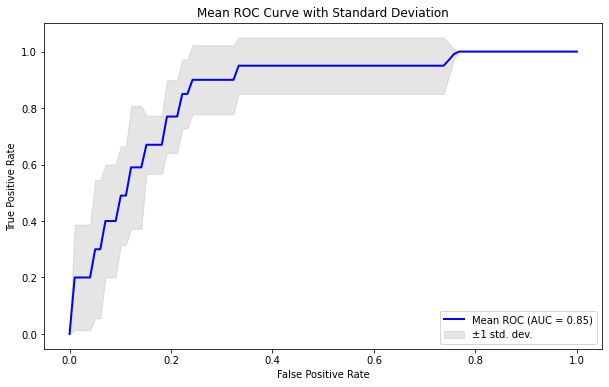

In [22]:
#xgboost auroc with nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_encoded_2[inputs_2a_run4]
y = df_encoded_2['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}


# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5

# make StratifiedKFold cross-validation iterator for outer CV
outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

#create list to store feature importances for each fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=3000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


In [61]:
#xgboost auroc with REPEATED (20x) nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# setup
X = df_encoded_2[inputs_2a_run5]
y = df_encoded_2['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5
n_repeats_outer = 20

# make RepeatedStratifiedKFold cross-validation iterator for outer CV
outer_cv = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

#create list to store feature importances for each fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
#plt.figure(figsize=(10, 6))
#plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
#plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Mean ROC Curve with Standard Deviation')
#plt.legend(loc='lower right')
#plt.show()



Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 2184 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   53.8s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.4s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.6s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.5s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.1s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.6s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1012 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   25.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   23.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.5s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.5s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   23.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.7s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.0s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.0s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.5s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1648 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.8s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   20.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.7s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   23.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   23.1s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   22.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   19.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   17.6s


Average AUROC Across Outer Folds: 0.8146337209302326
Standard Deviation of AUROC Across Outer Folds: 0.11131051182053286


[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   21.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.2s finished


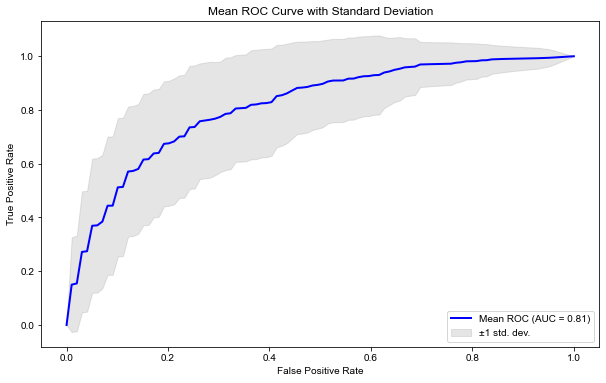

In [62]:
# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')

plt.savefig('2a_run5_auroc_graph.svg', format='svg')
plt.show()

In [12]:
len(outer_fold_results)

100

In [72]:
avg_feature_importances_2arun4 = [0.0145127644,
0.03632373,
0.0494950644,
0.0573905092,
0.081441497,
0.09095655,
0.094159966,
0.0947930042,
0.104949613,
0.110177038,
0.1317176888,
0.134082564]

In [83]:
for f in feature_importances:
    for i in f:
        print(i)
        
    print(" ")
    
    
for i in X_train.columns:
    print(i)

0.033061385
0.14316183
0.12513219
0.5099886
0.034618698
0.15403725
 
0.09910186
0.17984186
0.13870645
0.304753
0.058507036
0.21908984
 
0.12588349
0.1351964
0.1630119
0.25898734
0.12128718
0.1956337
 
0.0
0.11984849
0.117106795
0.44351467
0.0
0.3195301
 
0.13331184
0.1384264
0.12926497
0.28420192
0.11957575
0.19521914
 
tapsecmap4cviewmmode
rvs1tdicmsap4cviewtd
rvenddiastolicareacm2ap
rvendsystolicareacm2ap4
bsaonmri
rv_fac


In [79]:
avg_features_1a = [0.227449248,
0.08479753,
0.017493238,
0.262206272,
0.034100496,
0.2407132284,
0.0378129708,
0.035912066,
0.0595149368]

In [84]:
avg_features_3 = [0.078271715,
0.143294996,
0.134644461,
0.360289106,
0.0667977328,
0.216702006]

In [63]:
#get mean and std dev of feature importances 

col0 = []
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []
col7 = []
col8 = []
col9 = []
col10 = []


for f in feature_importances:
    
    count = 0
    for i in f:
        if count == 0:
            col0.append(i)
        if count == 1:
            col1.append(i)
        if count == 2:
            col2.append(i)
        if count == 3:
            col3.append(i)
        if count == 4:
            col4.append(i)
        if count == 5:
            col5.append(i)
        if count == 6:
            col6.append(i)
        if count == 7:
            col7.append(i)
        if count == 8:
            col8.append(i)
        if count == 9:
            col9.append(i)
        if count == 10:
            col10.append(i)
            
        count = count + 1
            
            


100

In [78]:
print(np.mean(col10))
print(np.std(col10))

0.049202
0.044261206


In [73]:
feature_names_2arun4 = ['tvannulusdimensionindiastole',
'heightonmri',
'age_y_at_echo',
'tvangulartiltdegreesap4c',
'pssapulmvalveannulusindiast',
'rvlengthenddiastolicdimensio',
'degreeofprbyechoreportif_5',
'rvbasalenddiastolicdimension',
'rvotproximal12oclockdiast',
'tapsecmap4cviewmmode',
'pslarvotdiastolicdimensionc',
'rvenddiastolicareacm2ap']

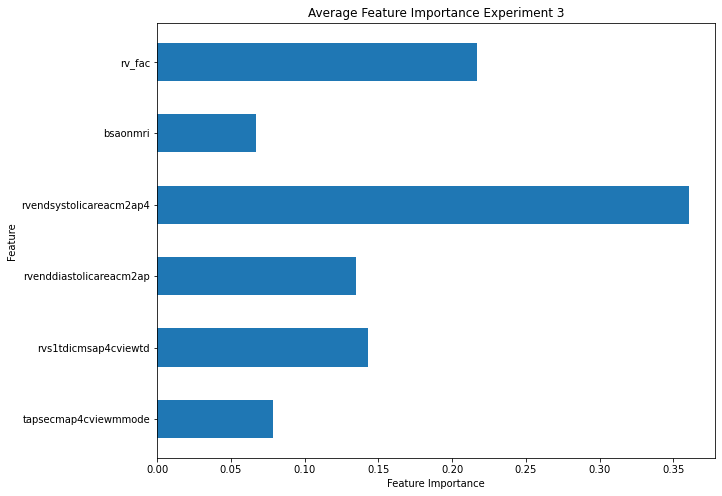

In [85]:
## get feature importance

feature_importance = avg_features_3
feature_names = X_train.columns


# Assuming feature_importance and feature_names are defined as in your code

# Plot feature importance
plt.figure(figsize=(10, 8))

# Set custom tick positions
tick_positions = np.arange(len(feature_importance)) * 1.5  # Adjust the multiplier to increase spacing

plt.barh(tick_positions, feature_importance, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Experiment 3')
plt.yticks(tick_positions, feature_names)  # Apply custom tick positions

plt.savefig("avg_feature_performance_3.svg", format='svg')


plt.show()


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   49.4s finished


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.8}
Average AUPRC Across Stratified Folds: 0.5564301888601088
Standard Deviation AUPRC Across Stratified Folds: 0.3144222416394299
Stratified Fold 1 AUPRC: 0.4410
Stratified Fold 2 AUPRC: 0.2142
Stratified Fold 3 AUPRC: 0.2745
Stratified Fold 4 AUPRC: 0.8524
Stratified Fold 5 AUPRC: 1.0000


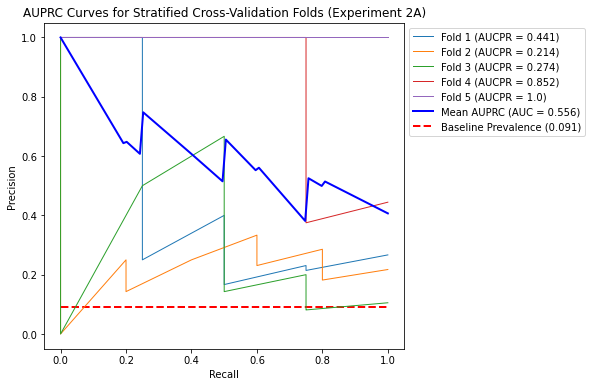

In [6]:
########## xgboost PR curves


from sklearn.metrics import precision_recall_curve, auc

# setup
X = df_encoded[inputs_2a]
y = df_encoded['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='average_precision',  # making avg precision our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))


# do stratification by outcome
scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model
    best_xgb_model.fit(X_train, y_train)

    #  probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # do PR curve vals
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # store precision and recall per fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # plot the PR curve for the current cross-validation fold
    ax.plot(recalls_list[fold], precisions_list[fold], lw=1, label=f'Fold {fold+1} (AUCPR = {round(auc_pr, 3)})')

    # Add AUC-PR to the scores list
    scores.append(auc_pr)

# calculate average AUC-PR score across all stratified folds
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Folds:", std_aucpr)

# Print AUROC scores for each stratified fold
for i, auprc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUPRC: {auprc:.4f}")

baseline_prevalence = y.mean()



# calculate the mean PR curve - must do sorting and interpolation to fit data correctly
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# plot  mean PR curve
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# plot the chance PR curve (should be a diagonal line from 0,1 to 1,0)
#plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2, label='Chance')

# Plot baseline prevalence as a horizontal line
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')


# Adjust layout to make room for the legend
plt.subplots_adjust(right=0.75)

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Other plot settings
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('AUPRC Curves for Stratified Cross-Validation Folds (Experiment 2A)')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    8.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    8.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    9.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.1s finished


Average AUPRC Across Group-Stratified Folds: 0.34378424643434596
Average AUPRC Across Group-Stratified Folds: 0.16970040172017054


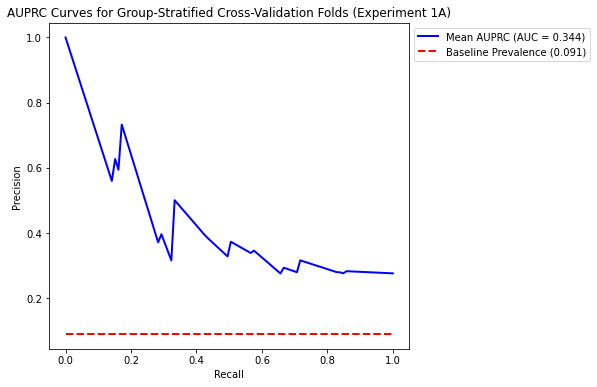

In [42]:
#xgboost pr curves with group strat + nested cv loops

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_encoded[inputs_2a_new_run7]
y = df_encoded['outcome_rvedvi_hi']
groups = df_encoded['mrn']  # Group identifier column

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# Number of splits for outer and inner cross-validation
n_splits_outer = 5
n_splits_inner = 3

# GroupKFold for outer cross-validation
outer_group_kfold = GroupKFold(n_splits=n_splits_outer)

# Lists to store results
precisions_list = []
recalls_list = []
average_aucpr_scores = []

# Outer cross-validation loop
for train_index, test_index in outer_group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups.iloc[train_index]

    # XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # GroupKFold for inner cross-validation (hyperparameter tuning)
    inner_group_kfold = GroupKFold(n_splits=n_splits_inner)

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='average_precision',
        cv=inner_group_kfold.split(X_train, y_train, groups_train),
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # PR curve values
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    precisions_list.append(precision)
    recalls_list.append(recall)

    # AUC-PR
    auc_pr = auc(recall, precision)
    average_aucpr_scores.append(auc_pr)

# Calculate and print the average and standard deviation performance across all outer folds
average_aucpr = np.mean(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", average_aucpr)
std_aucpr = np.std(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", std_aucpr)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
mean_recall = np.linspace(0, 1, 100)
precision_interp = []

# Interpolate and plot each fold's precision-recall curve
for recall, precision in zip(recalls_list, precisions_list):
    recall_sorted, precision_sorted = zip(*sorted(zip(recall, precision)))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

baseline_prevalence = y.mean()
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')

plt.subplots_adjust(right=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curves for Group-Stratified Cross-Validation Folds (Experiment 1A)')
plt.show()


In [41]:
#save 2A run 4 stuff

mean_precision_2A4 = mean_precision
mean_recall_2A4 = mean_recall
average_aucpr_2A4 = average_aucpr
std_aucpr_2A4 = std_aucpr
baseline_prevalence_2A4 = baseline_prevalence

In [43]:
mean_precision_2A7 = mean_precision
mean_recall_2A7 = mean_recall
average_aucpr_2A7 = average_aucpr
std_aucpr_2A7 = std_aucpr
baseline_prevalence_2A7 = baseline_prevalence

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 4616 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 7536 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 8985 out of 9000 | elapsed:   47.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   47.6s finished


Outer Fold 1 AUC-PR: 0.6822
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   53.2s finished


Outer Fold 2 AUC-PR: 0.1943
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   55.9s finished


Outer Fold 3 AUC-PR: 0.4127
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 8985 out of 9000 | elapsed:   53.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   53.6s finished


Outer Fold 4 AUC-PR: 0.6000
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 8985 out of 9000 | elapsed:   54.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   54.6s finished


Outer Fold 5 AUC-PR: 0.4225
Average AUPRC Across Stratified Outer Folds: 0.46235453213856115
Standard Deviation AUPRC Across Stratified Outer Folds: 0.16923476836158144


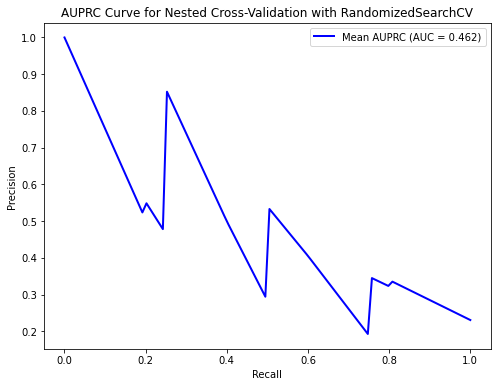

In [24]:
#pr curves using nested cv

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df_encoded_2[inputs_2a_run4]
y = df_encoded_2['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make StratifiedKFold cross-validation iterator for outer cross-validation
n_outer_splits = 5  # Number of outer splits
outer_stratified_kfold = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# Outer loop: iterate over outer folds
for outer_fold, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=3000,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {outer_fold+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
scores = [auc(recalls_list[i], precisions_list[i]) for i in range(len(recalls_list))]
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   20.2s finished


Outer Fold 1 AUC-PR: 0.6801
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished


Outer Fold 2 AUC-PR: 0.1728
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 3 AUC-PR: 0.3858
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 4 AUC-PR: 0.5913
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 5 AUC-PR: 0.2980
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 6 AUC-PR: 0.2702
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 7 AUC-PR: 0.7312
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 8 AUC-PR: 0.1355
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 9 AUC-PR: 0.7125
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 10 AUC-PR: 0.2653
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 11 AUC-PR: 0.3816
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 12 AUC-PR: 0.5109
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 13 AUC-PR: 0.2808
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 14 AUC-PR: 0.2448
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished


Outer Fold 15 AUC-PR: 0.7312
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 16 AUC-PR: 0.1982
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 17 AUC-PR: 0.3733
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished


Outer Fold 18 AUC-PR: 0.3500
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2457 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.5s finished


Outer Fold 19 AUC-PR: 0.2892
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 20 AUC-PR: 0.4677
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished


Outer Fold 21 AUC-PR: 0.3858
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 22 AUC-PR: 0.6713
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 23 AUC-PR: 0.6201
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 24 AUC-PR: 0.3599
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 25 AUC-PR: 0.7932
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 26 AUC-PR: 0.1197
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 27 AUC-PR: 0.5247
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 28 AUC-PR: 0.5392
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 29 AUC-PR: 0.1353
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 30 AUC-PR: 0.7464
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished


Outer Fold 31 AUC-PR: 0.5933
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 32 AUC-PR: 0.2513
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 33 AUC-PR: 0.1390
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 34 AUC-PR: 0.4771
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 35 AUC-PR: 0.2578
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 36 AUC-PR: 0.3441
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   18.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 37 AUC-PR: 0.4438
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 38 AUC-PR: 0.3618
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 39 AUC-PR: 0.6890
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 40 AUC-PR: 0.5426
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 41 AUC-PR: 0.3419
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 42 AUC-PR: 0.3742
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 43 AUC-PR: 0.2667
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 44 AUC-PR: 0.5985
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 45 AUC-PR: 0.5388
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 46 AUC-PR: 0.1920
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 47 AUC-PR: 0.5752
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished


Outer Fold 48 AUC-PR: 0.2251
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished


Outer Fold 49 AUC-PR: 0.2181
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 50 AUC-PR: 0.8771
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 51 AUC-PR: 0.5935
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished


Outer Fold 52 AUC-PR: 0.3118
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 53 AUC-PR: 0.1380
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 54 AUC-PR: 0.6423
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 55 AUC-PR: 0.3083
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 56 AUC-PR: 0.1692
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.8s finished


Outer Fold 57 AUC-PR: 0.9633
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 58 AUC-PR: 0.1839
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 59 AUC-PR: 0.4269
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 60 AUC-PR: 0.2921
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 61 AUC-PR: 0.9083
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.5s finished


Outer Fold 62 AUC-PR: 0.2649
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 63 AUC-PR: 0.2813
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 64 AUC-PR: 0.2496
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 65 AUC-PR: 0.1132
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 66 AUC-PR: 0.4481
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 67 AUC-PR: 0.1393
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 68 AUC-PR: 0.4340
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 69 AUC-PR: 0.9437
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 70 AUC-PR: 0.4216
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 71 AUC-PR: 0.1545
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 72 AUC-PR: 0.7764
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 73 AUC-PR: 0.6583
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 74 AUC-PR: 0.2205
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 75 AUC-PR: 0.2569
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished


Outer Fold 76 AUC-PR: 0.4475
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 77 AUC-PR: 0.5926
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 78 AUC-PR: 0.1247
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 79 AUC-PR: 0.2983
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 80 AUC-PR: 0.4545
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 81 AUC-PR: 0.3232
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 82 AUC-PR: 0.4412
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 83 AUC-PR: 0.1869
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 84 AUC-PR: 0.5268
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 85 AUC-PR: 0.6059
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 86 AUC-PR: 0.2133
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 87 AUC-PR: 0.6078
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 88 AUC-PR: 0.3414
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 89 AUC-PR: 0.5729
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 90 AUC-PR: 0.1216
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 91 AUC-PR: 0.5701
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 92 AUC-PR: 0.2583
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 93 AUC-PR: 0.3352
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   17.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.6s finished


Outer Fold 94 AUC-PR: 0.4175
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 95 AUC-PR: 0.3638
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 96 AUC-PR: 0.2159
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 97 AUC-PR: 0.6388
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   18.0s finished


Outer Fold 98 AUC-PR: 0.2441
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2368 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 99 AUC-PR: 0.4640
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.7s finished


Outer Fold 100 AUC-PR: 0.3102
Average AUPRC Across Stratified Outer Folds: 0.4124946430186141
Standard Deviation AUPRC Across Stratified Outer Folds: 0.2072071524037993


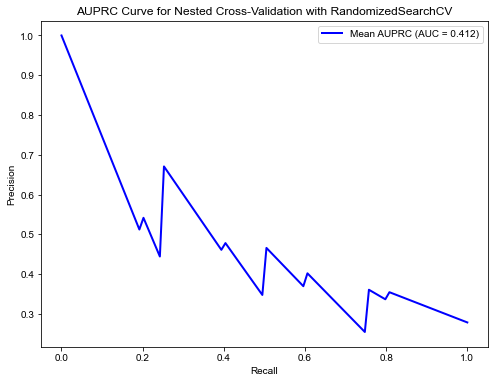

In [81]:
#pr curves using REPEATED nested cv

from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df_encoded_2[inputs_2a_run4]
y = df_encoded_2['outcome_rvedvi_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits and repeats for outer cross-validation
n_splits_outer = 5  # Number of outer splits
n_repeats_outer = 20  # Number of repeats

# make RepeatedStratifiedKFold cross-validation iterator for outer cross-validation
outer_repeated_stratified_kfold = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=42)

# Lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

outer_fold_auprcs = []

# Outer Cross-Validation loop
for i, (train_index, test_index) in enumerate(outer_repeated_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # add auc_pr to list
    outer_fold_auprcs.append(auc_pr)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {i+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
average_aucpr = np.mean(outer_fold_auprcs)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(outer_fold_auprcs)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


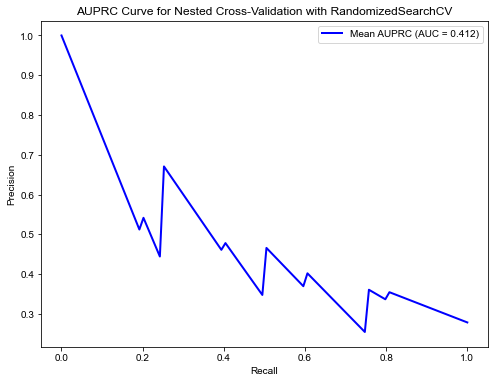

In [82]:
# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()

plt.savefig('2a_run4_auprc_graph.svg', format='svg')
plt.show()

In [15]:
#### Experiment 2B ####

inputs_2b = inputs_2a

df_2b = df_encoded

In [16]:
df_2b = df_2b.dropna(subset=['outcome_rvesv_hi'])

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   50.5s finished


Best Hyperparameters: {'subsample': 0.5, 'reg_lambda': 20.0, 'reg_alpha': 0.1, 'n_estimators': 25, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
Average AUROC Across Stratified Folds: 0.7446428571428572
Standard Deviation AUROC Across Stratified Folds: 0.0826742645180799
Stratified Fold 1 AUROC: 0.7357
Stratified Fold 2 AUROC: 0.8083
Stratified Fold 3 AUROC: 0.8625
Stratified Fold 4 AUROC: 0.6333
Stratified Fold 5 AUROC: 0.6833


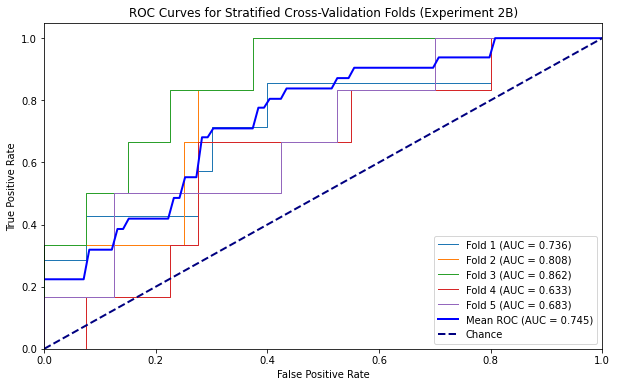

In [15]:
### xgboost auroc curves 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# setup
X = df_2b[inputs_2b]
y = df_2b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store fpr and tpr for each fold
fprs = []
tprs = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='roc_auc',  # making AUROC our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
plt.figure(figsize=(10, 6))

# do stratification by outcome

scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    auroc_fold_scores = []

    # Fit model
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUROC for the current fold
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Add to AUROC, TPR, FPR, and thresholds fold scores
    auroc_fold_scores.append(auroc)

    # Compute ROC curve for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Append fpr and tpr to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current cross-validation fold
    plt.step(fprs[fold], tprs[fold], lw=1, label=f'Fold {fold+1} (AUC = {round(auroc, 3)})')

    # Add to AUROC list
    scores.append(auroc)
    
# calculate average + std AUROC score across all stratified folds
average_auroc = np.mean(scores)
print("Average AUROC Across Stratified Folds:", average_auroc)

std_auroc = np.std(scores)
print("Standard Deviation AUROC Across Stratified Folds:", std_auroc)

# Print AUROC scores for each stratified fold
for i, auroc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUROC: {auroc:.4f}")

# Calculate the mean ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Choose the number of thresholds, here chose 100
tpr_interp = []

for fold in range(len(fprs)):
    tpr_interp.append(np.interp(mean_fpr, fprs[fold], tprs[fold]))

mean_tpr = np.mean(tpr_interp, axis=0)

# plot the average ROC curve and set labels
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Mean ROC (AUC = {round(average_auroc,3)})')

# other plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stratified Cross-Validation Folds (Experiment 2B)')
plt.legend(loc='lower right')
plt.show()


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1204 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2336 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   34.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   35.0s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   33.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   33.8s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   33.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   33.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   33.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   34.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   34.4s finished


Average AUROC Across Outer Folds: 0.6868452380952382
Standard Deviation of AUROC Across Outer Folds: 0.07183278485198692


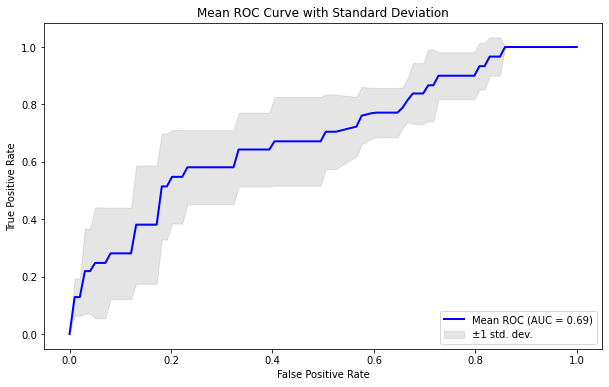

In [81]:
#xgboost auroc with nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_2b[inputs_2b]
y = df_2b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}


# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5

# make StratifiedKFold cross-validation iterator for outer CV
outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   54.0s finished


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.5}
Average AUPRC Across Stratified Folds: 0.4887576815246753
Standard Deviation AUPRC Across Stratified Folds: 0.19789091508115264
Stratified Fold 1 AUPRC: 0.5063
Stratified Fold 2 AUPRC: 0.4131
Stratified Fold 3 AUPRC: 0.7786
Stratified Fold 4 AUPRC: 0.1742
Stratified Fold 5 AUPRC: 0.5715


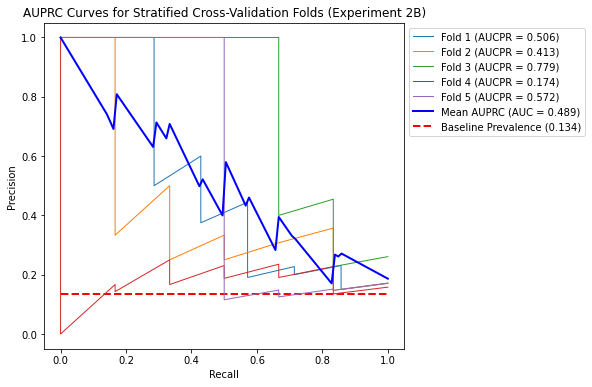

In [16]:
########## xgboost PR curves


from sklearn.metrics import precision_recall_curve, auc

# setup
X = df_2b[inputs_2b]
y = df_2b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='average_precision',  # making avg precision our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))


# do stratification by outcome
scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model
    best_xgb_model.fit(X_train, y_train)

    #  probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # do PR curve vals
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # store precision and recall per fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # plot the PR curve for the current cross-validation fold
    ax.plot(recalls_list[fold], precisions_list[fold], lw=1, label=f'Fold {fold+1} (AUCPR = {round(auc_pr, 3)})')

    # Add AUC-PR to the scores list
    scores.append(auc_pr)

# calculate average AUC-PR score across all stratified folds
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Folds:", std_aucpr)

# Print AUROC scores for each stratified fold
for i, auprc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUPRC: {auprc:.4f}")

baseline_prevalence = y.mean()



# calculate the mean PR curve - must do sorting and interpolation to fit data correctly
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# plot  mean PR curve
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# plot the chance PR curve (should be a diagonal line from 0,1 to 1,0)
#plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2, label='Chance')

# Plot baseline prevalence as a horizontal line
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')


# Adjust layout to make room for the legend
plt.subplots_adjust(right=0.75)

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Other plot settings
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('AUPRC Curves for Stratified Cross-Validation Folds (Experiment 2B)')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   12.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   13.0s finished


Outer Fold 1 AUC-PR: 0.4941
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.4s finished


Outer Fold 2 AUC-PR: 0.4243
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   14.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.4s finished


Outer Fold 3 AUC-PR: 0.3725
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   14.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.5s finished


Outer Fold 4 AUC-PR: 0.1378
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.3s finished


Outer Fold 5 AUC-PR: 0.4658
Average AUPRC Across Stratified Outer Folds: 0.3789135075597802
Standard Deviation AUPRC Across Stratified Outer Folds: 0.12733626852043567


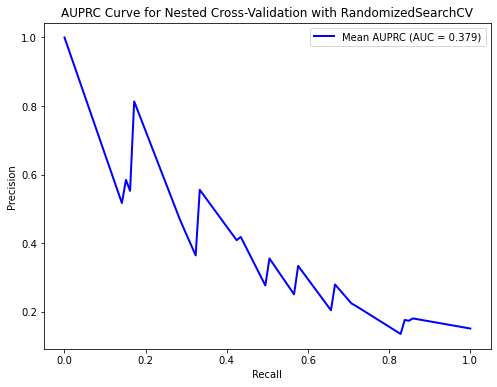

In [17]:
#pr curves using nested cv

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df_2b[inputs_2b]
y = df_2b['outcome_rvesv_hi']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make StratifiedKFold cross-validation iterator for outer cross-validation
n_outer_splits = 5  # Number of outer splits
outer_stratified_kfold = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# Outer loop: iterate over outer folds
for outer_fold, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {outer_fold+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
scores = [auc(recalls_list[i], precisions_list[i]) for i in range(len(recalls_list))]
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


In [7]:
##### Experiment 3 #####
inputs_3 = ['tapsecmap4cviewmmode','rvs1tdicmsap4cviewtd',
           'rvenddiastolicareacm2ap', 'rvendsystolicareacm2ap4',
           'bsaonmri', 'rv_fac']

In [8]:
df_3 = merge_df

In [9]:
df_3 = df_3.dropna(subset=['outcome_rvef_low'])

In [81]:
### xgboost auroc curves 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# setup
X = df_3[inputs_3]
y = df_3['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store fpr and tpr for each fold
fprs = []
tprs = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='roc_auc',  # making AUROC our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

#store feature importances for each fold
feature_importances = []

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
plt.figure(figsize=(10, 6))

# do stratification by outcome

scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    auroc_fold_scores = []

    # Fit model
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUROC for the current fold
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Add to AUROC, TPR, FPR, and thresholds fold scores
    auroc_fold_scores.append(auroc)

    # Compute ROC curve for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Append fpr and tpr to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current cross-validation fold
    plt.step(fprs[fold], tprs[fold], lw=1, label=f'Fold {fold+1} (AUC = {round(auroc, 3)})')

    # Add to AUROC list
    scores.append(auroc)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)
    
# calculate average + std AUROC score across all stratified folds
average_auroc = np.mean(scores)
print("Average AUROC Across Stratified Folds:", average_auroc)

std_auroc = np.std(scores)
print("Standard Deviation AUROC Across Stratified Folds:", std_auroc)

# Print AUROC scores for each stratified fold
for i, auroc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUROC: {auroc:.4f}")

# Calculate the mean ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Choose the number of thresholds, here chose 100
tpr_interp = []

for fold in range(len(fprs)):
    tpr_interp.append(np.interp(mean_fpr, fprs[fold], tprs[fold]))

mean_tpr = np.mean(tpr_interp, axis=0)

# plot the average ROC curve and set labels
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Mean ROC (AUC = {round(average_auroc,3)})')

# other plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stratified Cross-Validation Folds (Experiment 3)')
plt.legend(loc='lower right')
plt.show()


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    4.1s


WorkerInterrupt: 

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.2s finished


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    8.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    9.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.2s finished


Average AUROC Across Outer Folds: 0.7113424810483634
Standard Deviation of AUROC Across Outer Folds: 0.09362205965719303


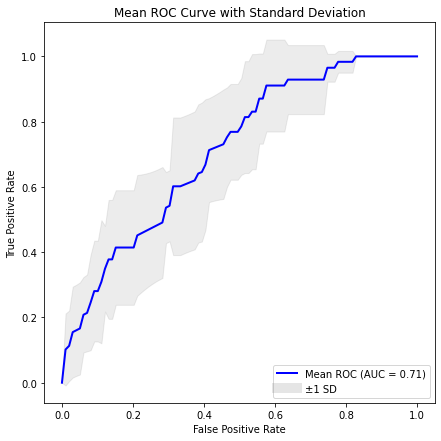

In [10]:
### xgboost auroc with group stratification and nested cv

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

X = df_3[inputs_3]
y = df_3['outcome_rvef_low']
groups = df_3['mrn']  # Group identifier

# Hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}

# XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Number of splits for cross-validation
n_splits_outer = 5

# GroupKFold for outer cross-validation
outer_cv = GroupKFold(n_splits=n_splits_outer)

# Lists for storing results
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)
tpr_interpolations = []

#store feature importances per fold
feature_importances = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # RandomizedSearchCV for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='roc_auc',
        cv=3,  # You can adjust this value
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0
    tpr_interpolations.append(tpr_interp)
    
    #get feature importance for fold
    fi = best_model.feature_importances_
    sum_fi = sum(fi)
    temp_fi = [x / sum_fi for x in fi]
    feature_importances.append(fi)

# Average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
#mean_tpr[-1] = 1.0
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves
plt.figure(figsize=(7, 7))
plt.plot(mean_fprs, mean_tpr, color='b', lw=2, label=f'Mean ROC (AUC = {average_performance:.2f})')
plt.fill_between(mean_fprs, mean_tpr - std_tpr, mean_tpr + std_tpr, color='gray', alpha=0.15)

plt.plot([], [], color='grey', alpha=0.2, linewidth=10, label='±1 SD')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.savefig("roc_curve_with_std_3.svg", format='svg')

plt.show()


In [11]:
mean_fprs3 = mean_fprs
mean_tpr3 = mean_tpr
average_performance3 = average_performance
std_tpr3 = std_tpr

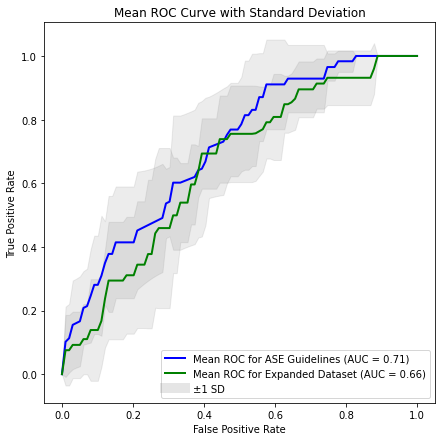

In [21]:
# Plotting the ROC curves - overlayed plot with exp 4
plt.figure(figsize=(7, 7))
plt.plot(mean_fprs3, mean_tpr3, color='b', lw=2, label=f'Mean ROC for ASE Guidelines (AUC = {average_performance3:.2f})')
plt.fill_between(mean_fprs3, mean_tpr3 - std_tpr3, mean_tpr3 + std_tpr3, color='gray', alpha=0.15)

plt.plot(mean_fprs, mean_tpr, color='g', lw=2, label=f'Mean ROC for Expanded Dataset (AUC = {average_performance:.2f})')
plt.fill_between(mean_fprs, mean_tpr - std_tpr, mean_tpr + std_tpr, color='gray', alpha=0.15)

plt.plot([], [], color='grey', alpha=0.2, linewidth=10, label='±1 SD')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.savefig("roc_curve_rvef_overlayed.svg", format='svg')

plt.show()

In [ ]:
mean_recall3 = mean_recall
mean_precision4 = mean_precision
average_aucpr4 = average_aucpr
baseline_prevalence4 = baseline_prevalence

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   16.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   17.4s finished


Average AUROC Across Outer Folds: 0.7024182076813654
Standard Deviation of AUROC Across Outer Folds: 0.08024023523328024


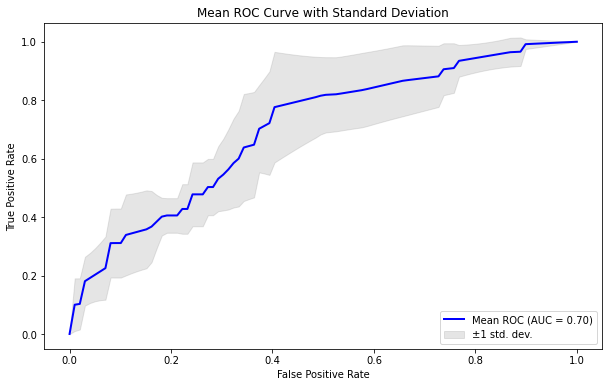

In [85]:
#xgboost auroc with nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_3[inputs_3]
y = df_3['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}


# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5

# make StratifiedKFold cross-validation iterator for outer CV
outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


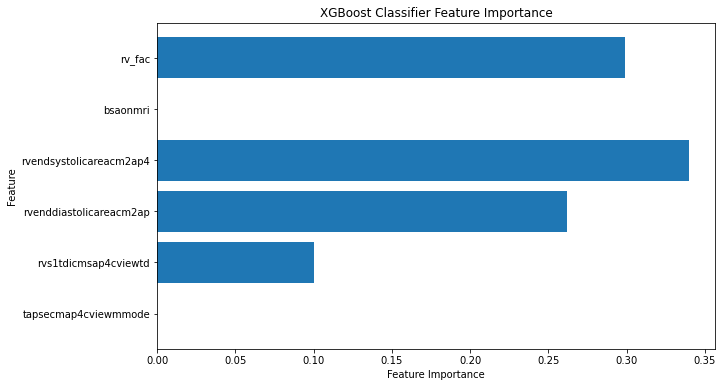

In [48]:
## get feature importance

feature_importance = best_xgb_model.feature_importances_
feature_names = X_train.columns
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Classifier Feature Importance')
plt.show()

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 4985 out of 5000 | elapsed:   22.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   22.5s finished


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.0, 'n_estimators': 100, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.8}
Average AUPRC Across Stratified Folds: 0.45783137880169206
Standard Deviation AUPRC Across Stratified Folds: 0.0871994293301559
Stratified Fold 1 AUPRC: 0.3535
Stratified Fold 2 AUPRC: 0.3835
Stratified Fold 3 AUPRC: 0.4528
Stratified Fold 4 AUPRC: 0.5983
Stratified Fold 5 AUPRC: 0.5010


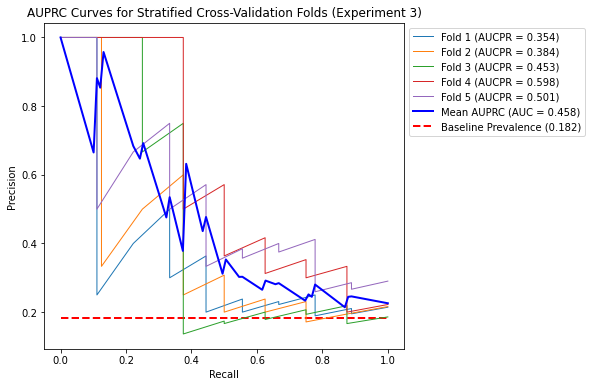

In [24]:
########## xgboost PR curves


from sklearn.metrics import precision_recall_curve, auc

# setup
X = df_3[inputs_3]
y = df_3['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='average_precision',  # making avg precision our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))


# do stratification by outcome
scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model
    best_xgb_model.fit(X_train, y_train)

    #  probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # do PR curve vals
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # store precision and recall per fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # plot the PR curve for the current cross-validation fold
    ax.plot(recalls_list[fold], precisions_list[fold], lw=1, label=f'Fold {fold+1} (AUCPR = {round(auc_pr, 3)})')

    # Add AUC-PR to the scores list
    scores.append(auc_pr)

# calculate average AUC-PR score across all stratified folds
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Folds:", std_aucpr)

# Print AUROC scores for each stratified fold
for i, auprc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUPRC: {auprc:.4f}")

baseline_prevalence = y.mean()



# calculate the mean PR curve - must do sorting and interpolation to fit data correctly
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# plot  mean PR curve
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# plot the chance PR curve (should be a diagonal line from 0,1 to 1,0)
#plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2, label='Chance')

# Plot baseline prevalence as a horizontal line
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')


# Adjust layout to make room for the legend
plt.subplots_adjust(right=0.75)

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Other plot settings
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('AUPRC Curves for Stratified Cross-Validation Folds (Experiment 3)')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    6.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1485 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.6s finished


Average AUPRC Across Group-Stratified Folds: 0.3908212405462426
Average AUPRC Across Group-Stratified Folds: 0.15892710341055322


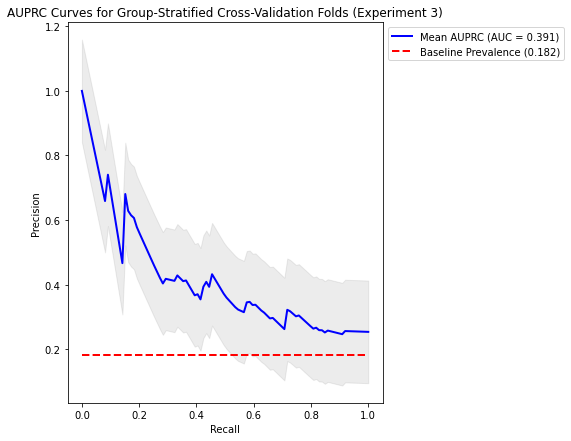

In [29]:
#xgboost pr curves with group strat + nested cv loops

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_3[inputs_3]
y = df_3['outcome_rvef_low']
groups = df_3['mrn']  # Group identifier column

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# Number of splits for outer and inner cross-validation
n_splits_outer = 5
n_splits_inner = 3

# GroupKFold for outer cross-validation
outer_group_kfold = GroupKFold(n_splits=n_splits_outer)

# Lists to store results
precisions_list = []
recalls_list = []
average_aucpr_scores = []

# Outer cross-validation loop
for train_index, test_index in outer_group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups.iloc[train_index]

    # XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # GroupKFold for inner cross-validation (hyperparameter tuning)
    inner_group_kfold = GroupKFold(n_splits=n_splits_inner)

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='average_precision',
        cv=inner_group_kfold.split(X_train, y_train, groups_train),
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # PR curve values
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    precisions_list.append(precision)
    recalls_list.append(recall)

    # AUC-PR
    auc_pr = auc(recall, precision)
    average_aucpr_scores.append(auc_pr)

# Calculate and print the average and standard deviation performance across all outer folds
average_aucpr = np.mean(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", average_aucpr)
std_aucpr = np.std(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", std_aucpr)

# Plotting
fig, ax = plt.subplots(figsize=(7, 7))
mean_recall = np.linspace(0, 1, 100)
precision_interp = []

# Interpolate and plot each fold's precision-recall curve
for recall, precision in zip(recalls_list, precisions_list):
    recall_sorted, precision_sorted = zip(*sorted(zip(recall, precision)))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

baseline_prevalence = y.mean()
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')

ax.fill_between(mean_recall, mean_precision - std_aucpr, mean_precision + std_aucpr, color='gray', alpha=0.15)


plt.subplots_adjust(right=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curves for Group-Stratified Cross-Validation Folds (Experiment 3)')
plt.savefig("pr_curve_with_std_3.svg", format='svg')

plt.show()


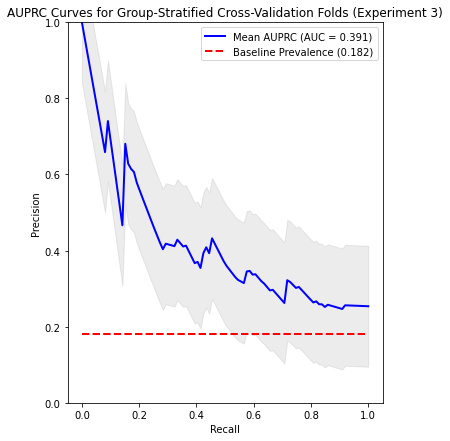

In [58]:
# Plotting
fig, ax = plt.subplots(figsize=(7, 7))
mean_recall = np.linspace(0, 1, 100)
precision_interp = []

# Interpolate and plot each fold's precision-recall curve
for recall, precision in zip(recalls_list, precisions_list):
    recall_sorted, precision_sorted = zip(*sorted(zip(recall, precision)))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

baseline_prevalence = y.mean()
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')

ax.fill_between(mean_recall, mean_precision - std_aucpr, mean_precision + std_aucpr, color='gray', alpha=0.15)
plt.ylim([0, 1])  # Setting y-axis limits from 0 to 1


plt.subplots_adjust(right=0.75)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curves for Group-Stratified Cross-Validation Folds (Experiment 3)')
plt.savefig("pr_curve_with_std_3.svg", format='svg')

plt.show()

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 1 AUC-PR: 0.2176
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 2 AUC-PR: 0.4796
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 3 AUC-PR: 0.3589
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 4 AUC-PR: 0.5561
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:    7.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.7s finished


Outer Fold 5 AUC-PR: 0.5445
Average AUPRC Across Stratified Outer Folds: 0.431339285255761
Standard Deviation AUPRC Across Stratified Outer Folds: 0.12775452356068384


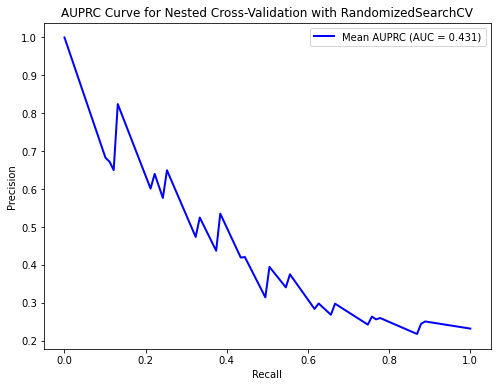

In [21]:
#pr curves using nested cv

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df_3[inputs_3]
y = df_3['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make StratifiedKFold cross-validation iterator for outer cross-validation
n_outer_splits = 5  # Number of outer splits
outer_stratified_kfold = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# Outer loop: iterate over outer folds
for outer_fold, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {outer_fold+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
scores = [auc(recalls_list[i], precisions_list[i]) for i in range(len(recalls_list))]
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()


In [16]:
#### Experiment 4 #####

inputs_4 = inputs_2a

In [17]:
df_4 = df_encoded

In [18]:
df_4 = df_4.dropna(subset=['outcome_rvef_low'])

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 3812 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   50.6s finished


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.5, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Average AUROC Across Stratified Folds: 0.7728524577208787
Standard Deviation AUROC Across Stratified Folds: 0.07921346684129961
Stratified Fold 1 AUROC: 0.7485
Stratified Fold 2 AUROC: 0.7730
Stratified Fold 3 AUROC: 0.6382
Stratified Fold 4 AUROC: 0.8487
Stratified Fold 5 AUROC: 0.8559


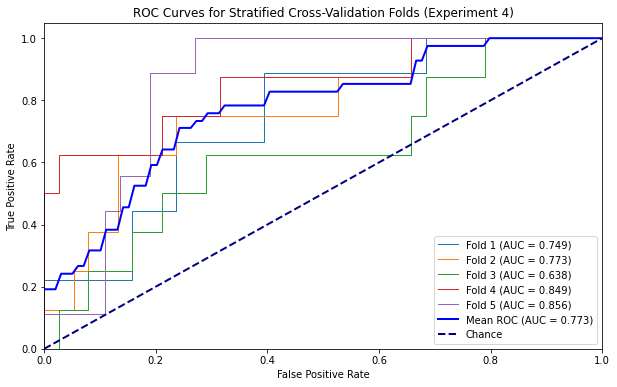

In [52]:
### xgboost auroc curves 

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# setup
X = df_4[inputs_4]
y = df_4['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store fpr and tpr for each fold
fprs = []
tprs = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='roc_auc',  # making AUROC our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
plt.figure(figsize=(10, 6))

# do stratification by outcome

scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    auroc_fold_scores = []

    # Fit model
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calculate AUROC for the current fold
    auroc = roc_auc_score(y_test, y_pred_prob)

    # Add to AUROC, TPR, FPR, and thresholds fold scores
    auroc_fold_scores.append(auroc)

    # Compute ROC curve for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Append fpr and tpr to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current cross-validation fold
    plt.step(fprs[fold], tprs[fold], lw=1, label=f'Fold {fold+1} (AUC = {round(auroc, 3)})')

    # Add to AUROC list
    scores.append(auroc)
    
# calculate average + std AUROC score across all stratified folds
average_auroc = np.mean(scores)
print("Average AUROC Across Stratified Folds:", average_auroc)

std_auroc = np.std(scores)
print("Standard Deviation AUROC Across Stratified Folds:", std_auroc)

# Print AUROC scores for each stratified fold
for i, auroc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUROC: {auroc:.4f}")

# Calculate the mean ROC curve
mean_fpr = np.linspace(0, 1, 100)  # Choose the number of thresholds, here chose 100
tpr_interp = []

for fold in range(len(fprs)):
    tpr_interp.append(np.interp(mean_fpr, fprs[fold], tprs[fold]))

mean_tpr = np.mean(tpr_interp, axis=0)

# plot the average ROC curve and set labels
plt.plot(mean_fpr, mean_tpr, color='b', linestyle='-', lw=2, label=f'Mean ROC (AUC = {round(average_auroc,3)})')

# other plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stratified Cross-Validation Folds (Experiment 4)')
plt.legend(loc='lower right')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1172 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   19.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   18.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   19.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   19.4s finished


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   20.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   20.2s finished


Average AUROC Across Outer Folds: 0.6557555189908131
Standard Deviation of AUROC Across Outer Folds: 0.09012106506630835


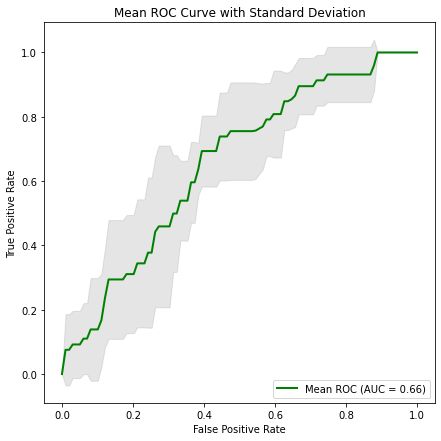

In [19]:
### xgboost auroc with group stratification and nested cv

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

X = df_4[inputs_4]
y = df_4['outcome_rvef_low']
groups = df_4['mrn']  # Group identifier

# Hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}

# XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Number of splits for cross-validation
n_splits_outer = 5

# GroupKFold for outer cross-validation
outer_cv = GroupKFold(n_splits=n_splits_outer)

# Lists for storing results
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)
tpr_interpolations = []

y_train_vals = []
y_test_vals = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # RandomizedSearchCV for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='roc_auc',
        cv=3,  # You can adjust this value
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0
    tpr_interpolations.append(tpr_interp)
    
    y_train_vals.append(y_train)
    y_test_vals.append(y_test)

# Average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves
plt.figure(figsize=(7, 7))
plt.plot(mean_fprs, mean_tpr, color='g', lw=2, label=f'Mean ROC (AUC = {average_performance:.2f})')
plt.fill_between(mean_fprs, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')

plt.savefig("roc_curve_4.svg", format='svg')

plt.show()


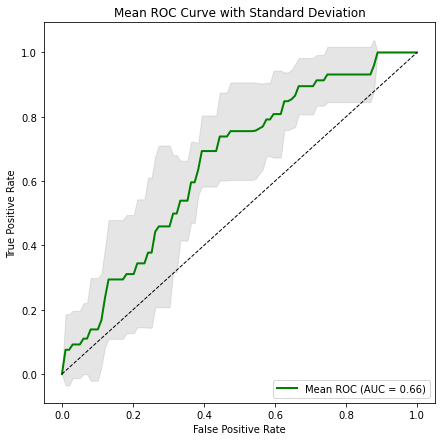

In [18]:
# Plotting the ROC curves
plt.figure(figsize=(7, 7))
plt.plot(mean_fprs, mean_tpr, color='g', lw=2, label=f'Mean ROC (AUC = {average_performance:.2f})')
plt.fill_between(mean_fprs, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')

# Add line representing chance
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', label='Chance')


plt.savefig("roc_curve_4.svg", format='svg')

plt.show()

In [69]:
#y_train_vals[1]

temp=0
for i in y_test_vals[4]:
    temp += i

print(temp)

11.0


In [71]:
5/47  #0.16 - 0.201

   #0.106 - 0.255

0.10638297872340426

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   35.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   35.7s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   34.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   34.3s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 2985 out of 3000 | elapsed:   34.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   34.8s finished


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1978 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 2868 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   34.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   33.9s finished


Average AUROC Across Outer Folds: 0.7206733048838313
Standard Deviation of AUROC Across Outer Folds: 0.08511158621405275


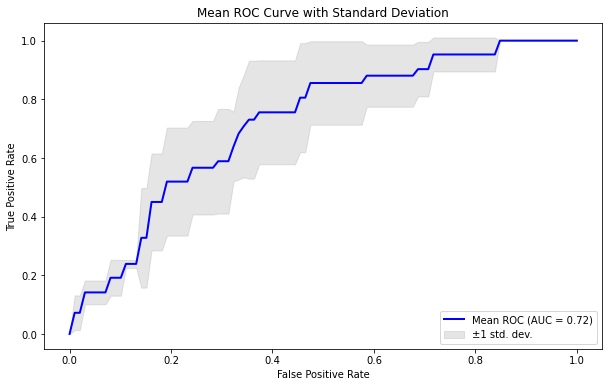

In [89]:
#xgboost auroc with nested cross validation

import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_4[inputs_4]
y = df_4['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0.0, 1.0, 10.0],
    'reg_lambda': [0.0, 1.0, 10.0],
    'gamma': [0, 1.0, 5.0],
    'min_child_weight': [1, 10, 20]
}


# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the number of splits for both inner and outer cross-validation
n_splits_inner = 3
n_splits_outer = 5

# make StratifiedKFold cross-validation iterator for outer CV
outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

# Lists to store results of each outer fold
outer_fold_results = []
mean_fprs = np.linspace(0, 1, 100)  # Define evenly spaced FPR values for interpolation
tpr_interpolations = []

# Outer Cross-Validation loop
for train_index, test_index in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # make StratifiedKFold cross-validation iterator for inner CV (hyperparameter tuning)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    # make RandomizedSearchCV object for hyperparameter tuning within each outer fold
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=1000,
        scoring='roc_auc',
        cv=inner_cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Perform hyperparameter tuning on the training data of the outer fold
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    outer_fold_results.append(auroc)

    # ROC curve for the outer fold
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    tpr_interp = np.interp(mean_fprs, fpr, tpr)
    tpr_interp[0] = 0.0  # Ensure starting at 0
    tpr_interpolations.append(tpr_interp)

# Calculate and print the average performance across all outer folds
average_performance = np.mean(outer_fold_results)
std_dev_performance = np.std(outer_fold_results)
print("Average AUROC Across Outer Folds:", average_performance)
print("Standard Deviation of AUROC Across Outer Folds:", std_dev_performance)

# Compute mean and standard deviation of the interpolated TPR
mean_tpr = np.mean(tpr_interpolations, axis=0)
mean_tpr[-1] = 1.0  # Ensure ending at 1
std_tpr = np.std(tpr_interpolations, axis=0)

# Plotting the ROC curves with shading for standard deviation
plt.figure(figsize=(10, 6))
plt.plot(mean_fprs, mean_tpr, color='b', label=f'Mean ROC (AUC = {average_performance:.2f})', lw=2)
plt.fill_between(mean_fprs, mean_tpr-std_tpr, mean_tpr+std_tpr, color='grey', alpha=0.2, label='±1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Standard Deviation')
plt.legend(loc='lower right')
plt.show()


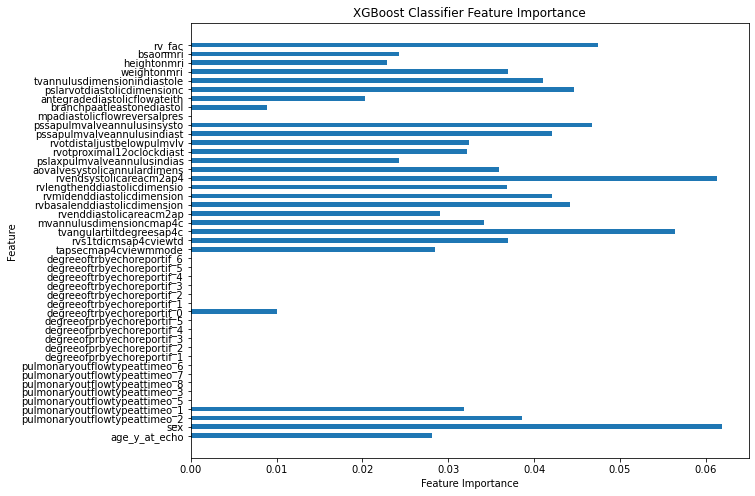

In [55]:
## get feature importance

feature_importance = best_xgb_model.feature_importances_
feature_names = X_train.columns
# Plot feature importance
plt.figure(figsize=(10, 8))

# Set custom tick positions
tick_positions = np.arange(len(feature_importance)) * 1.5  # Adjust the multiplier to increase spacing

plt.barh(tick_positions, feature_importance, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Classifier Feature Importance')
plt.yticks(tick_positions, feature_names)  # Apply custom tick positions

plt.show()

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 3788 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   54.4s finished


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.0, 'reg_alpha': 0.5, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Average AUPRC Across Stratified Folds: 0.4801690589208679
Standard Deviation AUPRC Across Stratified Folds: 0.1498309363414869
Stratified Fold 1 AUPRC: 0.4723
Stratified Fold 2 AUPRC: 0.4503
Stratified Fold 3 AUPRC: 0.2549
Stratified Fold 4 AUPRC: 0.7256
Stratified Fold 5 AUPRC: 0.4977


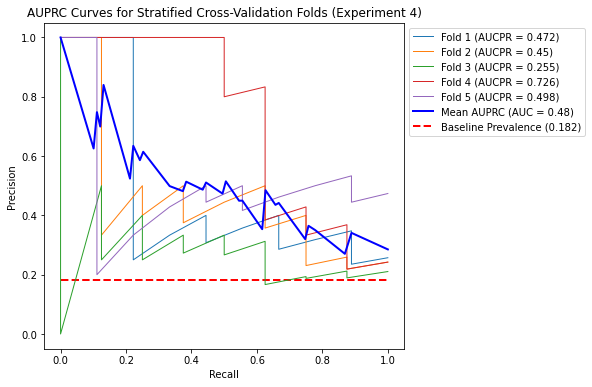

In [32]:
########## xgboost PR curves


from sklearn.metrics import precision_recall_curve, auc

# setup
X = df_4[inputs_4]
y = df_4['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# make StratifiedKFold cross-validation iterator for outcome stratification
n_splits = 5  # Number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# make RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=1000,  # chose the number of random parameter combinations to try
    scoring='average_precision',  # making avg precision our scoring metric
    cv=stratified_kfold.split(X, y),  # Use stratified folds for outcome stratification
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# fit RandomizedSearchCV object on our data for hyperparameter tuning
random_search.fit(X, y)

# save best hyperparameters and best model from the random search
best_params = random_search.best_params_
best_xgb_model = random_search.best_estimator_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

# make plot for figure outside of loop to be able to overlay all plots at the end
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8, 6))


# do stratification by outcome
scores = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model
    best_xgb_model.fit(X_train, y_train)

    #  probabilities
    y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

    # do PR curve vals
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    # store precision and recall per fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # plot the PR curve for the current cross-validation fold
    ax.plot(recalls_list[fold], precisions_list[fold], lw=1, label=f'Fold {fold+1} (AUCPR = {round(auc_pr, 3)})')

    # Add AUC-PR to the scores list
    scores.append(auc_pr)

# calculate average AUC-PR score across all stratified folds
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Folds:", std_aucpr)

# Print AUROC scores for each stratified fold
for i, auprc in enumerate(scores):
    print(f"Stratified Fold {i+1} AUPRC: {auprc:.4f}")

baseline_prevalence = y.mean()



# calculate the mean PR curve - must do sorting and interpolation to fit data correctly
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# plot  mean PR curve
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# plot the chance PR curve (should be a diagonal line from 0,1 to 1,0)
#plt.plot([0, 1], [1, 0], color='gray', linestyle='--', lw=2, label='Chance')

# Plot baseline prevalence as a horizontal line
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')


# Adjust layout to make room for the legend
plt.subplots_adjust(right=0.75)

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Other plot settings
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('AUPRC Curves for Stratified Cross-Validation Folds (Experiment 4)')
plt.show()


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   14.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.7s finished


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   16.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.1s finished


Average AUPRC Across Group-Stratified Folds: 0.3261415630090598
Average AUPRC Across Group-Stratified Folds: 0.17017334156798333


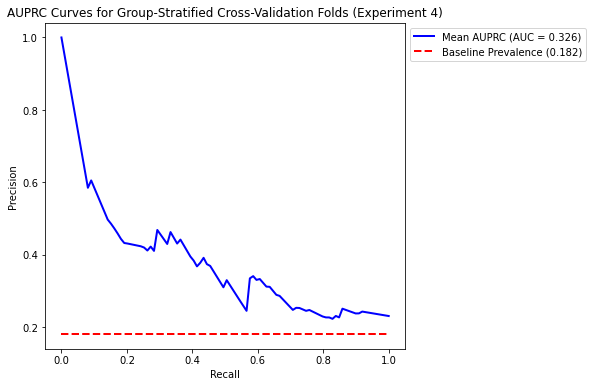

In [27]:
#xgboost pr curves with group strat + nested cv loops

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# setup
X = df_4[inputs_4]
y = df_4['outcome_rvef_low']
groups = df_4['mrn']  # Group identifier column

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# Number of splits for outer and inner cross-validation
n_splits_outer = 5
n_splits_inner = 3

# GroupKFold for outer cross-validation
outer_group_kfold = GroupKFold(n_splits=n_splits_outer)

# Lists to store results
precisions_list = []
recalls_list = []
average_aucpr_scores = []

# Outer cross-validation loop
for train_index, test_index in outer_group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    groups_train = groups.iloc[train_index]

    # XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # GroupKFold for inner cross-validation (hyperparameter tuning)
    inner_group_kfold = GroupKFold(n_splits=n_splits_inner)

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='average_precision',
        cv=inner_group_kfold.split(X_train, y_train, groups_train),
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    # Hyperparameter tuning
    random_search.fit(X_train, y_train)

    # Best model for this outer fold
    best_model = random_search.best_estimator_

    # Evaluate the best model on the test set of the outer fold
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    # PR curve values
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    precisions_list.append(precision)
    recalls_list.append(recall)

    # AUC-PR
    auc_pr = auc(recall, precision)
    average_aucpr_scores.append(auc_pr)

# Calculate and print the average and standard deviation performance across all outer folds
average_aucpr = np.mean(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", average_aucpr)
std_aucpr = np.std(average_aucpr_scores)
print("Average AUPRC Across Group-Stratified Folds:", std_aucpr)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
mean_recall = np.linspace(0, 1, 100)
precision_interp = []

# Interpolate and plot each fold's precision-recall curve
for recall, precision in zip(recalls_list, precisions_list):
    recall_sorted, precision_sorted = zip(*sorted(zip(recall, precision)))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)
ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

baseline_prevalence = y.mean()
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')

plt.subplots_adjust(right=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curves for Group-Stratified Cross-Validation Folds (Experiment 4)')

plt.savefig('pr_curve_exp_4.svg')
plt.show()


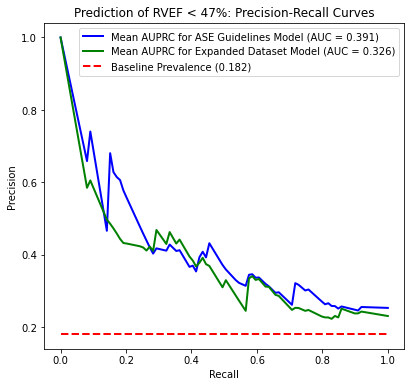

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC for ASE Guidelines Model (AUC = {round(average_aucpr, 3)})')
ax.plot(mean_recall4, mean_precision4, color='g', linestyle='-', lw=2, label=f'Mean AUPRC for Expanded Dataset Model (AUC = {round(average_aucpr4, 3)})')



baseline_prevalence = y.mean()
ax.hlines(baseline_prevalence, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline Prevalence ({round(baseline_prevalence, 3)})')



plt.subplots_adjust(right=0.75)
plt.legend(loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Prediction of RVEF < 47%: Precision-Recall Curves')

plt.savefig('pr_curves_rvef_overlayed.svg')
plt.savefig('pr_curves_rvef_overlayed.png')

plt.show()

In [28]:
mean_recall4 = mean_recall
mean_precision4 = mean_precision
average_aucpr4 = average_aucpr
baseline_prevalence4 = baseline_prevalence

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   15.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.8s finished


Outer Fold 1 AUC-PR: 0.3435
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1485 out of 1500 | elapsed:   15.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.3s finished


Outer Fold 2 AUC-PR: 0.3856
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 3 AUC-PR: 0.1980
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Outer Fold 4 AUC-PR: 0.5526
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   15.7s finished


Outer Fold 5 AUC-PR: 0.2965
Average AUPRC Across Stratified Outer Folds: 0.35524417425820143
Standard Deviation AUPRC Across Stratified Outer Folds: 0.11675593709762451


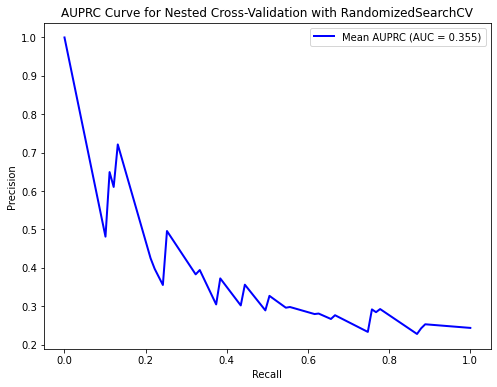

In [25]:
#pr curves using nested cv

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# setup
X = df_4[inputs_4]
y = df_4['outcome_rvef_low']

# hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'learning_rate': [0.1],
    'n_estimators': [10, 25, 50, 100, 200],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
    'gamma': [0, 0.1, 0.5, 1.0, 5.0, 10, 20],
    'min_child_weight': [0.1, 0.5, 1, 5, 10, 20, 25]
}

# make StratifiedKFold cross-validation iterator for outer cross-validation
n_outer_splits = 5  # Number of outer splits
outer_stratified_kfold = StratifiedKFold(n_splits=n_outer_splits, shuffle=True, random_state=42)

# Add empty lists to store precision and recall for each fold
precisions_list = []
recalls_list = []

# Outer loop: iterate over outer folds
for outer_fold, (train_index, test_index) in enumerate(outer_stratified_kfold.split(X, y)):
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

    # make XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # make StratifiedKFold cross-validation iterator for inner cross-validation
    n_inner_splits = 3  # Number of inner splits
    inner_stratified_kfold = StratifiedKFold(n_splits=n_inner_splits, shuffle=True, random_state=42)

    # make RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=500,  # chose the number of random parameter combinations to try
        scoring='average_precision',  # making avg precision our scoring metric
        cv=inner_stratified_kfold.split(X_train_outer, y_train_outer),  # Use stratified folds for outcome stratification
        verbose=2,
        n_jobs=-1
    )

    # fit RandomizedSearchCV object on training data for hyperparameter tuning
    random_search.fit(X_train_outer, y_train_outer)

    # save best hyperparameters and best model from the random search
    best_params = random_search.best_params_
    best_xgb_model = random_search.best_estimator_

    # fit best model on the entire training set from the outer fold
    best_xgb_model.fit(X_train_outer, y_train_outer)

    # predict probabilities on the test set from the outer fold
    y_pred_prob = best_xgb_model.predict_proba(X_test_outer)[:, 1]

    # compute PR curve values
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_prob)

    # store precision and recall per outer fold
    precisions_list.append(precision)
    recalls_list.append(recall)

    # calculate Area Under the Precision-Recall Curve (AUC-PR)
    auc_pr = auc(recall, precision)

    # print AUC-PR for the outer fold
    print(f"Outer Fold {outer_fold+1} AUC-PR: {auc_pr:.4f}")

# calculate the mean PR curve
mean_recall = np.linspace(0, 1, 100)  # choose number of thresholds, here chose 100
precision_interp = []

for fold in range(len(recalls_list)):
    # must sort recalls first before interpolation
    recall_sorted, precision_sorted = zip(*sorted(zip(recalls_list[fold], precisions_list[fold])))
    precision_interp.append(np.interp(mean_recall, recall_sorted, precision_sorted))

mean_precision = np.mean(precision_interp, axis=0)

# calculate average AUC-PR score across all outer folds
scores = [auc(recalls_list[i], precisions_list[i]) for i in range(len(recalls_list))]
average_aucpr = np.mean(scores)
print("Average AUPRC Across Stratified Outer Folds:", average_aucpr)

std_aucpr = np.std(scores)
print("Standard Deviation AUPRC Across Stratified Outer Folds:", std_aucpr)

# plot mean PR curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, color='b', linestyle='-', lw=2, label=f'Mean AUPRC (AUC = {round(average_aucpr, 3)})')

# Other plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AUPRC Curve for Nested Cross-Validation with RandomizedSearchCV')
plt.legend()
plt.show()
